Surface data file loaded: /Users/william/Desktop/Thesis-AES/Data/XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data.txt
Downhole data file loaded: /Users/william/Desktop/Thesis-AES/Data/XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Downhole Gauge_Data.TXT
surface time min/max: (Timestamp('2023-12-10 14:42:58'), Timestamp('2023-12-10 17:33:17'))
downhole time min/max: (Timestamp('2023-12-09 21:24:09'), Timestamp('2023-12-11 01:33:42'))
shut-in times:  2546   2023-12-10 15:25:19
7451   2023-12-10 16:47:02
9155   2023-12-10 17:15:23
Name: Time, dtype: datetime64[ns]
Estimated delay: 1.0252777777777777 h


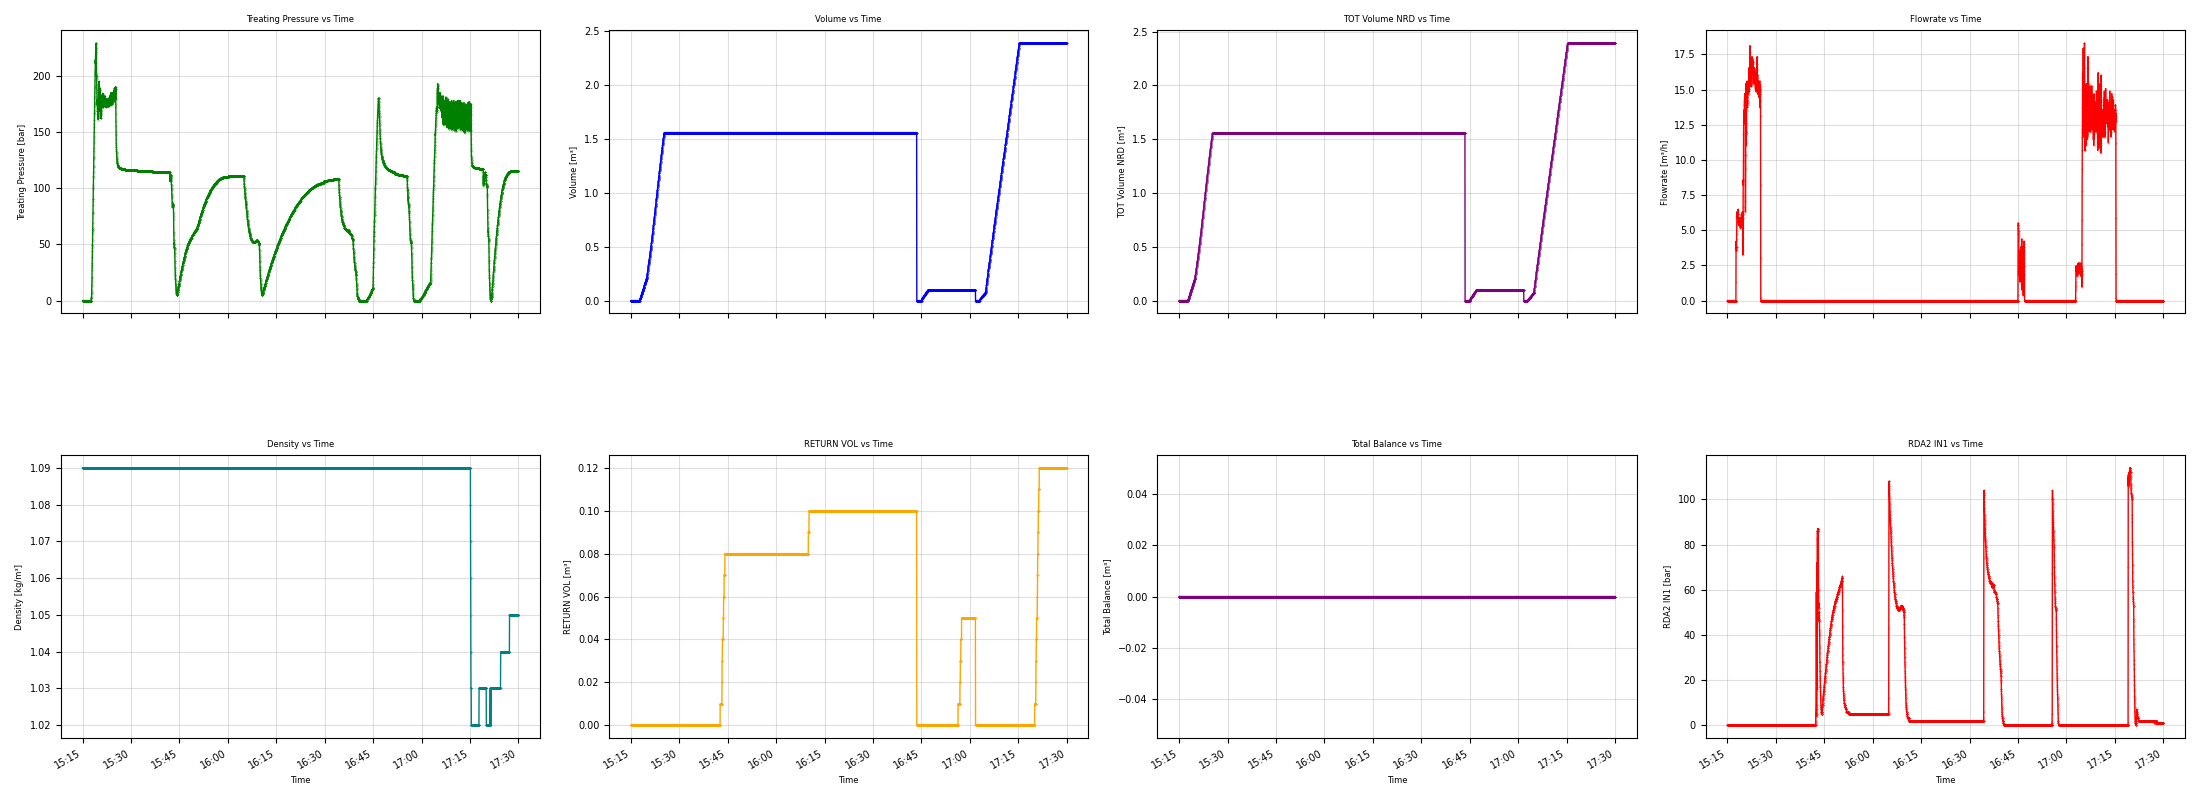

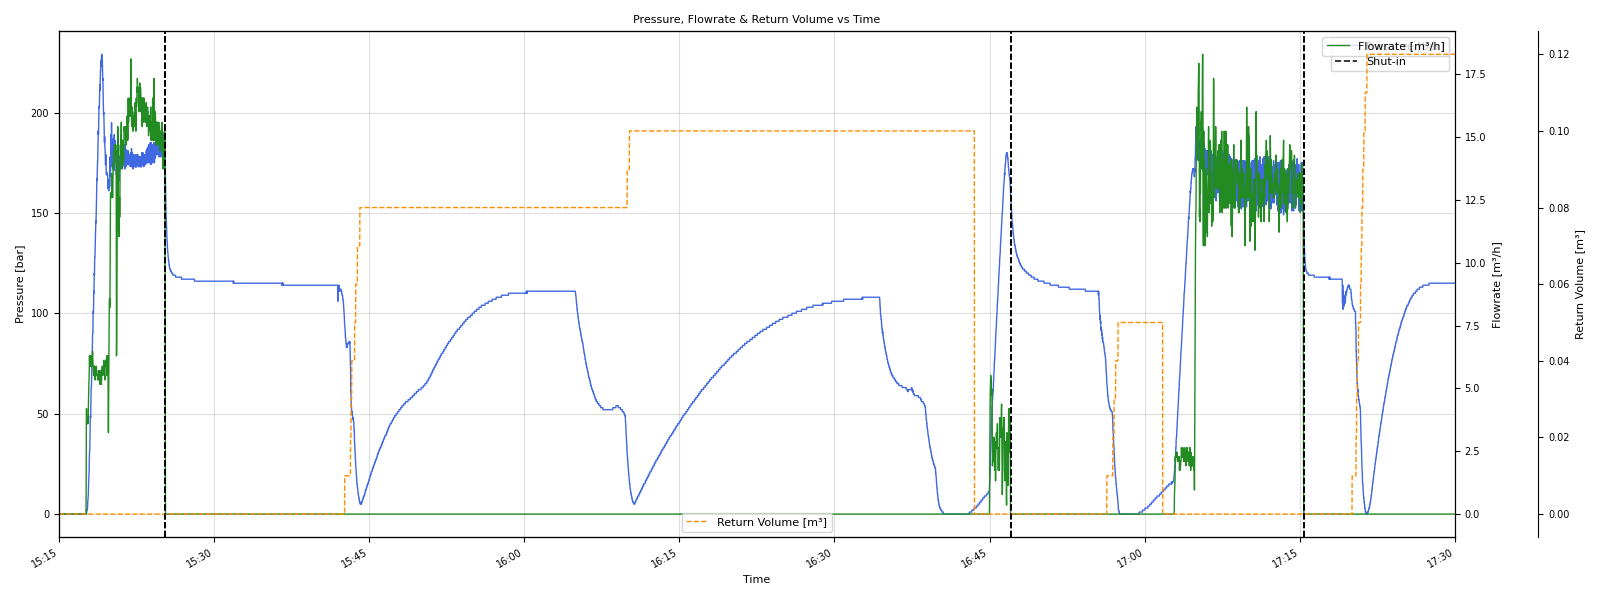

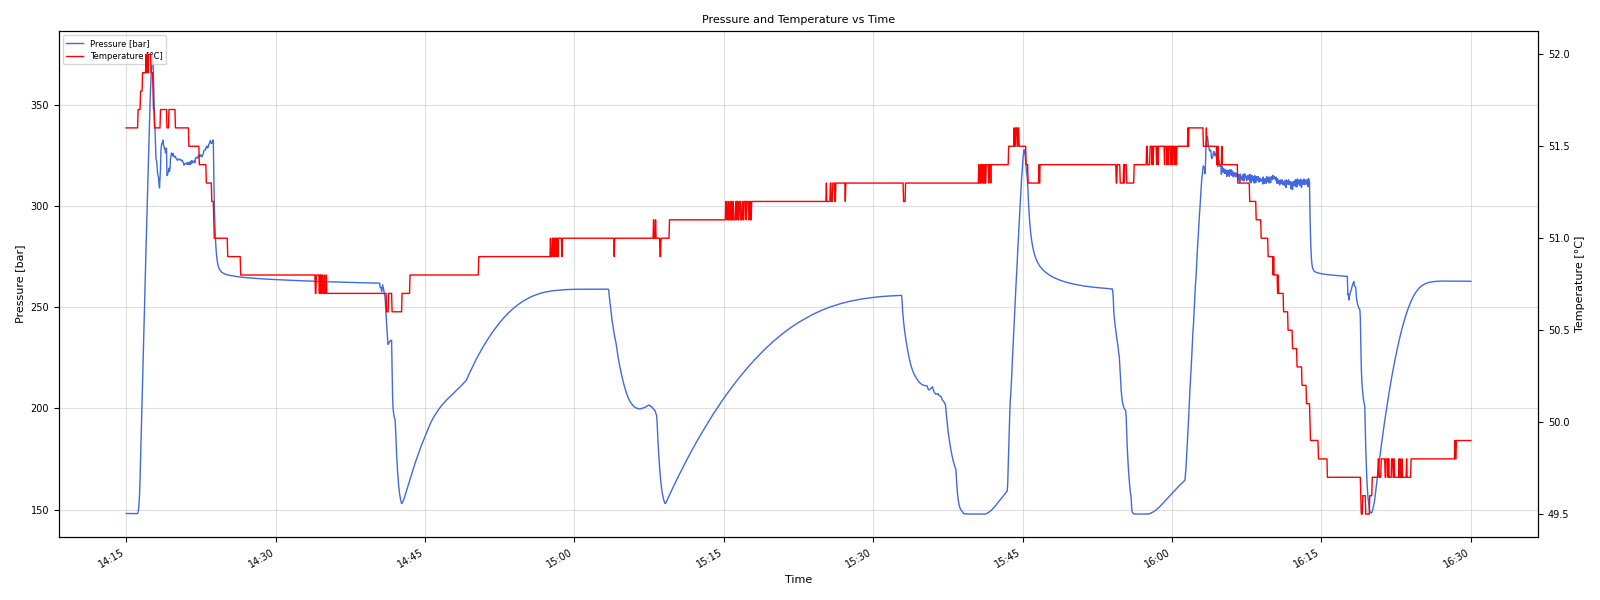

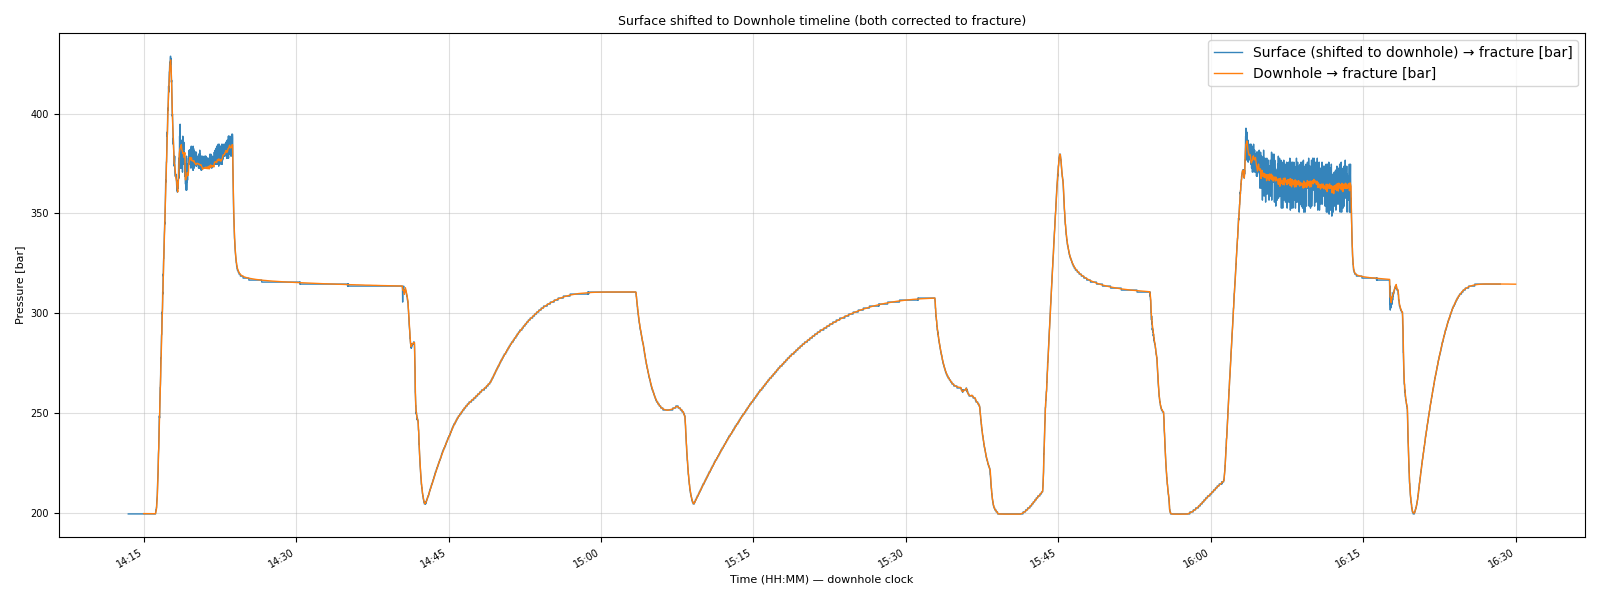

In [17]:
from pathlib import Path
import pandas as pd 
import numpy as np
%matplotlib widget 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

# Local modules
from old_code import time_difference
from old_code import well_corrections
from old_code import closure_analysis
from old_code import plotting

# ----------------------------
# File paths (cross-platform)
# ----------------------------
base = Path("Data") 

SURF_PATH = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data.txt"
DOWN_PATH = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Downhole Gauge_Data.TXT"

CAP_S = 210                     # analyze/plot max 3.5 minutes

USE_MANUAL_SHUTIN = True        # automatically detect shut-in based on pumping rate

# ----------------------------
# Helpers
# ----------------------------
def to_num(series):
    """
    Normalize numeric text: strip whitespace, remove NBSPs, comma→dot, coerce to float.
    Returns a pandas Series[float].
    """
    s = pd.Series(series, copy=False)
    if s.dtype.kind in "biufc":
        return pd.to_numeric(s, errors="coerce")
    s = s.astype(str).str.strip()
    s = s.str.replace('\u00A0', '', regex=False)   # NBSP
    s = s.str.replace(',', '.', regex=False)       # decimal comma -> dot
    s = s.replace({'': None})
    return pd.to_numeric(s, errors='coerce')

def get_or_nan(df, col):
    """Return numeric series for existing column or a NaN series matching df length."""
    if col in df.columns:
        return to_num(df[col])
    return pd.Series([np.nan] * len(df), index=df.index, dtype=float)


# ----------------------------
# Example usage
# ----------------------------
dfS = pd.read_csv(SURF_PATH, sep="\t", engine="python", on_bad_lines="skip")
dfD = pd.read_csv(DOWN_PATH, sep="\t", engine="python", on_bad_lines="skip")

print("Surface data file loaded:", SURF_PATH.resolve())
print("Downhole data file loaded:", DOWN_PATH.resolve())

# Ensure expected columns exist for downhole file
dfD.columns = ['Time', 'Delta Time', 'Pressure', 'Temperature', 'None', 'None2']

# Slice away headers/units lines typical of these exports
dfS = dfS.iloc[1:].reset_index(drop=True)
dfD = dfD.iloc[4:, :-2].reset_index(drop=True)  # drop last two 'None' cols

# ----------------------------
# Parse time columns
# ----------------------------
# Surface time format: %m:%d:%Y:%H:%M:%S
time_surface = pd.to_datetime(dfS['Time'], format='%m:%d:%Y:%H:%M:%S', errors='coerce')

# Downhole time format: %d-%m-%Y %H:%M:%S
time_downhole = pd.to_datetime(dfD['Time'].astype(str).str.strip(),
                               format='%d-%m-%Y %H:%M:%S', errors='coerce')

# ----------------------------
# Numeric columns (Surface)
# ----------------------------
pressure_S          = get_or_nan(dfS, 'Treating Pressure')
flowrate_S          = get_or_nan(dfS, 'Flow Rate') * 0.06 # l/min -> m³/hour
density_S           = get_or_nan(dfS, 'Density')
volume_S            = get_or_nan(dfS, 'Volume')
tot_volume_nrd_S    = get_or_nan(dfS, 'TOT vol nrd')
volume_nrd_S        = get_or_nan(dfS, 'NRD VOLUME')
return_volume_S     = get_or_nan(dfS, 'RETURN VOL')
totbalance_volume_S = get_or_nan(dfS, 'total bla')  # may not exist in some files
RDA_pressure_S      = get_or_nan(dfS, 'RDA2 IN1')

# ----------------------------
# Numeric columns (Downhole)
# ----------------------------
delta_time_D  = to_num(dfD['Delta Time'])
pressure_D    = to_num(dfD['Pressure']) * 0.0689476  # psi -> bar
temperature_D = to_num(dfD['Temperature'])

# ----------------------------
# Time windows
# ----------------------------
startS = pd.to_datetime("2023-12-10 15:15:00")
endS   = pd.to_datetime("2023-12-10 17:30:00")

startD = pd.to_datetime("2023-12-10 14:15:00")
endD   = pd.to_datetime("2023-12-10 16:30:00")

# ----------------------------
# Masks (NaN-safe)
# ----------------------------
maskS = (
    pressure_S.notna() &
    time_surface.notna() &
    (RDA_pressure_S.fillna(np.inf) <= 2000) &
    (time_surface >= startS) & (time_surface <= endS)
)

time_S               = time_surface[maskS]
pressure_S           = pressure_S[maskS]
flowrate_S           = flowrate_S[maskS]
density_S            = density_S[maskS]
volume_S             = volume_S[maskS]
tot_volume_nrd_S     = tot_volume_nrd_S[maskS]
volume_nrd_S         = volume_nrd_S[maskS]
return_volume_S      = return_volume_S[maskS]
totbalance_volume_S  = totbalance_volume_S[maskS]
RDA_pressure_S       = RDA_pressure_S[maskS]

print('surface time min/max:', (time_surface.min(), time_surface.max()))

maskD = (
    time_downhole.notna() &
    pressure_D.notna() &
    temperature_D.notna() &
    (time_downhole >= startD) & (time_downhole <= endD)
)

time_D        = time_downhole[maskD]
delta_time_D  = delta_time_D[maskD]
pressure_D    = pressure_D[maskD]
temperature_D = temperature_D[maskD]

print('downhole time min/max:', (time_downhole.min(), time_downhole.max()))

# ----------------------------
# Surface panels
# ----------------------------
fig1, axs1 = plotting.plot_surface_panels(
    time_S, pressure_S, flowrate_S, density_S, volume_S,
    tot_volume_nrd_S, return_volume_S, totbalance_volume_S, RDA_pressure_S,
    figsize=(22, 8), markersize=0.2, linewidth=1.0, tick_labelsize=7, title_labelsize=6
)

# ----------------------------
# Triple-axis (surface subset)
# ----------------------------
fig2, (ax1, ax2, ax3) = plotting.plot_triple_axis(
    time_S, pressure_S, flowrate_S, return_volume_S,
    start=startS, end=endS, figsize=(16, 6)
)

# --- Simple shut-in lines on Figure 2 (plot_triple_axis) ---

q_thresh = 0.2  # m³/h threshold for "pumping" vs "shut-in"

is_pumping = (flowrate_S.fillna(0.0) > q_thresh)
shut_in_mask = is_pumping.shift(1, fill_value=False) & (~is_pumping)
shut_in_times = pd.to_datetime(time_S[shut_in_mask])
print('shut-in times: ', shut_in_times)

for ts in shut_in_times:
    for ax in (ax1, ax2, ax3):
        ax.axvline(ts, color="k", linestyle="--", linewidth=1.2, alpha=0.9)

# Add legend entry (optional)
if len(shut_in_times) > 0:
    ax1.axvline(shut_in_times.iloc[0], color="k", linestyle="--", linewidth=1.2, alpha=0.9, label="Shut-in")
    for ax in (ax1, ax2, ax3):
        h, l = ax.get_legend_handles_labels()
        if l:
            ax.legend(h, l, loc="best", fontsize=8)


# ----------------------------
# Downhole P/T plot
# ----------------------------
fig3, (ax4, ax5) = plotting.plot_downhole_pt(time_D, pressure_D, temperature_D, figsize=(16, 6))

# ----------------------------
# Depths & lag estimation
# ----------------------------
# Example MD/TVD arrays; replace with real values
MD = np.array([1364, 1383, 1383.3], dtype=float)
TVD = np.array([1363.18, np.nan, 1382.31], dtype=float)  # NaN = missing value
TVD_fracture_m = 1866.50
gauge_index    = 1  # index of the downhole gauge in the MD/TVD arrays

# Surface gauge is x m ABOVE TVD=0  → TVD_surface_sensor_m = -x (down is +)
TVD_surface_sensor_m = -1.46
delta_tvd_surface_to_frac = TVD_fracture_m - TVD_surface_sensor_m  # = TVD_fracture_m + 1.46


# NOTE: we use the (MD, TVD, gauge_index, TVD_fracture_m) signature per the fixed helper
TVD_interp, TVD_gauge_m, delta_tvd_m = well_corrections.estimate_lag(MD, TVD, gauge_index, TVD_fracture_m)

# Estimate delay (surface vs downhole)
try:
    lag_s, grid_step = time_difference.estimate_delay_seconds_robust(
        time_S, pressure_S,
        time_D, pressure_D,
        max_lag_s=4*3600,    # 4 hours
        detrend_window_s=120
    )
except Exception as e:
    print("Delay estimation failed; defaulting lag_s=0. Reason:", e)
    lag_s = 0.0
print(f"Estimated delay: {float(lag_s)/3600} h")
# To align SURFACE to DOWNHOLE we shift SURFACE by **-lag_s**.

# ----------------------------
# Hydrostatic corrections to fracture depth
# ----------------------------
# Surface pressure corrected to fracture (if surface sensor is at TVD≈0, ΔTVD≈TVD_fracture_m)
p_surface_corr, _ = well_corrections.hydrostatic_correct_to_fracture(
    p_gauge=pressure_S,      # SURFACE treating pressure [bar]
    time_gauge=time_S,
    rho_surface=density_S,   # surface density series
    time_surface=time_S,
    delta_tvd_m=delta_tvd_surface_to_frac,  # surface(0) -> fracture
    out_units='bar',
    lag_s=None
)

# Downhole gauge corrected to fracture
p_downhole_corr, _ = well_corrections.hydrostatic_correct_to_fracture(
    p_gauge=pressure_D,      # DOWNHOLE gauge [bar]
    time_gauge=time_D,
    rho_surface=density_S,   # use surface density aligned to DH via lag_s
    time_surface=time_S,
    delta_tvd_m=delta_tvd_m, # TVD_fracture - TVD_gauge
    out_units='bar',
    lag_s=lag_s
)

# ----------------------------
# Build aligned timelines (DOWNHOLE clock)
# ----------------------------
surface_dt_orig  = pd.to_datetime(time_S)
downhole_dt_orig = pd.to_datetime(time_D)

# Shift SURFACE timestamps by **-lag_s** to align onto DOWNHOLE clock
surface_dt_aligned_to_dh = surface_dt_orig - pd.to_timedelta(float(lag_s), unit='s')

y_surface  = pd.Series(p_surface_corr, copy=False).astype(float).to_numpy()
y_downhole = pd.Series(p_downhole_corr, copy=False).astype(float).to_numpy()

# Plot alignment (datetime)
figA, axA = plotting.plot_alignment(surface_dt_aligned_to_dh, y_surface, downhole_dt_orig, y_downhole, figsize=(16, 6))



In [2]:
print('surfac first datapoint:', y_surface[0])
print('downhole first datapoint: ', y_downhole[0])
print(len(dfS))



surfac first datapoint: 199.67088628059997
downhole first datapoint:  199.834619586443
10230


auto shut-in times: [Timestamp('2023-12-10 15:25:19'), Timestamp('2023-12-10 16:47:02'), Timestamp('2023-12-10 17:15:23')]


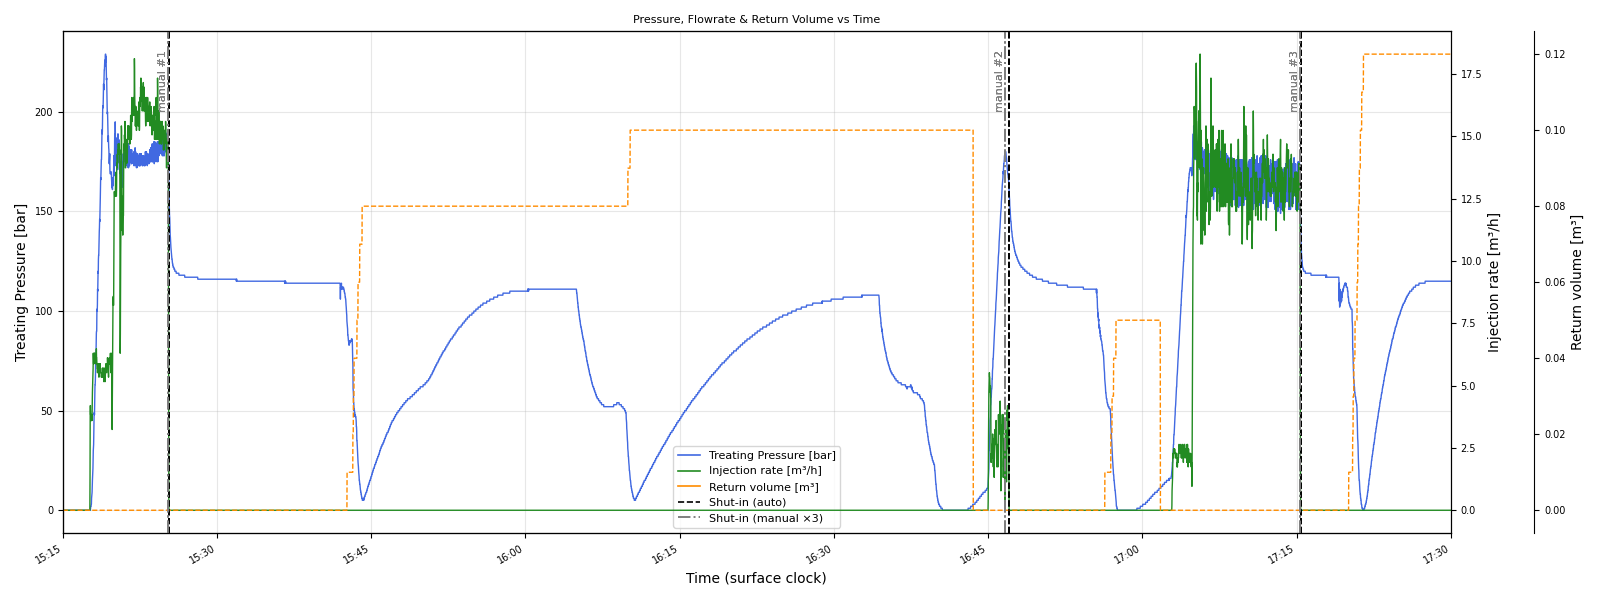

In [3]:
# ----------------------------
# Self-contained manual + auto shut-in overlay
# Legend uses actual line colors from plot_triple_axis
# ----------------------------
from matplotlib.lines import Line2D

# 1) Make the base figure (identical to your fig2)
fig2, (ax1, ax2, ax3) = plotting.plot_triple_axis(
    time_S, pressure_S, flowrate_S, return_volume_S,
    start=startS, end=endS, figsize=(16, 6)
)

# 2) Axis labels (keep your wording)
ax1.set_ylabel("Treating Pressure [bar]", fontsize=10)
ax2.set_ylabel("Injection rate [m³/h]", fontsize=10)
ax3.set_ylabel("Return volume [m³]", fontsize=10)
ax1.set_xlabel("Time (surface clock)", fontsize=10)
ax1.grid(True, alpha=0.3)

# 3) Determine the actual colors used by the three axes
def _pick_color(ax, fallback):
    return (ax.lines[0].get_color() if ax.lines else fallback)

col_p  = _pick_color(ax1, "C3")  # pressure
col_q  = _pick_color(ax2, "C0")  # injection
col_rv = _pick_color(ax3, "C2")  # return volume

# 4) Auto + manual shut-in times (supports multiple manuals)
USE_MANUAL_SHUTIN     = True
MANUAL_SHUTINS_SURFACE = [
    "2023-12-10 15:25:16",
    "2023-12-10 16:46:40",
    "2023-12-10 17:15:19",
]  # set to [] or None to skip

q_thresh = 0.2  # m³/h
is_pumping   = (flowrate_S.fillna(0.0) > q_thresh)
shut_in_mask = is_pumping.shift(1, fill_value=False) & (~is_pumping)
auto_shut_in_times = pd.DatetimeIndex(pd.to_datetime(time_S[shut_in_mask])).dropna().unique().sort_values()
print("auto shut-in times:", list(auto_shut_in_times))

# Snap manual timestamps to nearest sample
def _snap_to_series(ts_str_list, series_like):
    if not ts_str_list:
        return pd.DatetimeIndex([])
    tvals = pd.to_datetime(series_like).values.astype("datetime64[ns]")
    snapped = []
    for s in ts_str_list:
        req = np.datetime64(pd.Timestamp(s))
        idx = int(np.argmin(np.abs(tvals - req)))
        snapped.append(pd.Timestamp(tvals[idx]))
    # unique + sorted
    return pd.DatetimeIndex(snapped).unique().sort_values()

manual_shut_in_times = pd.DatetimeIndex([])
if USE_MANUAL_SHUTIN and MANUAL_SHUTINS_SURFACE:
    manual_shut_in_times = _snap_to_series(MANUAL_SHUTINS_SURFACE, time_S)

# Remove autos that are “the same” as a manual within a tolerance
# (prevents double lines when the manual is just a few seconds off)
dt_tol = pd.Timedelta(seconds=0)  # adjust if your sampling is coarser/finer
def _filter_autos_with_tolerance(autos, manuals, tol):
    if len(manuals) == 0:
        return autos
    keep = []
    for a in autos:
        if not any(abs(a - m) <= tol for m in manuals):
            keep.append(a)
    return pd.DatetimeIndex(keep)

autos_to_draw = _filter_autos_with_tolerance(auto_shut_in_times, manual_shut_in_times, dt_tol)

# 5) Draw shut-ins
for ts in autos_to_draw:
    for ax in (ax1, ax2, ax3):
        ax.axvline(ts, color="k", linestyle="--", linewidth=1.2, alpha=0.9)

if len(manual_shut_in_times) > 0:
    for i, ts in enumerate(manual_shut_in_times, start=1):
        for ax in (ax1, ax2, ax3):
            ax.axvline(ts, color="C7", linestyle="-.", linewidth=1.4, alpha=0.95)
            ytop = ax.get_ylim()[1]
            ax.text(ts, ytop*0.96, f"manual #{i}", color="C7",
                    rotation=90, va="top", ha="right", fontsize=8)

# 6) Build a single legend with your names + real colors
handles, labels = [], []
handles.append(Line2D([0], [0], color=col_p, lw=1.2));  labels.append("Treating Pressure [bar]")
handles.append(Line2D([0], [0], color=col_q, lw=1.2));  labels.append("Injection rate [m³/h]")
handles.append(Line2D([0], [0], color=col_rv, lw=1.2)); labels.append("Return volume [m³]")
if len(autos_to_draw) > 0:
    handles.append(Line2D([0], [0], color="k", linestyle="--", lw=1.2)); labels.append("Shut-in (auto)")
if len(manual_shut_in_times) > 0:
    handles.append(Line2D([0], [0], color="C7", linestyle="-.", lw=1.4)); labels.append("Shut-in (manual ×{})".format(len(manual_shut_in_times)))
ax1.legend(handles, labels, loc="best", fontsize=8, frameon=True)

# 7) Rescale and render
for ax in (ax1, ax2, ax3):
    ax.relim(); ax.autoscale_view()

fig2.tight_layout()
fig2.canvas.draw_idle()
plt.show()

In [4]:
import numpy as np
import pandas as pd

def cycles_from_volume(volume_S, tol=1e-3, drop_partial_leading=True):
    """
    Infer pump cycles from a cumulative surface volume series.

    A cycle:
      - t_start = the **last zero** (v < tol) just before volume increases
      - t_end   = the **first zero** (v < tol) after pumping stops

    Parameters
    ----------
    volume_S : array-like or pd.Series
        Cumulative injected volume. Index may be datetime or numeric.
    tol : float
        Threshold below which volume is considered "zero".
    drop_partial_leading : bool
        If True and the series starts already pumping (no zero seen yet),
        skip that partial first cycle instead of fabricating a start.

    Returns
    -------
    pd.DataFrame with columns:
        ['start_idx','end_idx','t_start','t_end','duration',
         'start_value','end_value','samples']
    'duration' is a Timedelta if the index is datetime-like; otherwise a float count.
    """
    v = pd.Series(volume_S).astype(float)
    idx = v.index

    # Identify zero/nonzero states
    is_zero = v < tol

    # Transitions:
    #   zero -> nonzero : pumping starts (start boundary index i)
    start_boundary = (is_zero.shift(1, fill_value=False)) & (~is_zero)
    #   nonzero -> zero : pumping stops (end boundary index j)
    end_boundary   = (~is_zero.shift(1, fill_value=False)) & (is_zero)

    start_idx = np.flatnonzero(start_boundary.values)
    end_idx   = np.flatnonzero(end_boundary.values)

    # Each cycle pairs a start (last zero just before rise) with the next end (first zero)
    starts = []
    ends   = []

    s_ptr = 0
    e_ptr = 0

    # If series begins already pumping (first state nonzero), optionally drop that partial
    if not is_zero.iloc[0]:
        if not drop_partial_leading:
            # fabricate a start at the very first index
            starts.append(0)
        # else: wait for the first proper zero->nonzero transition
    # Walk both transition arrays
    while s_ptr < len(start_idx):
        s_i = start_idx[s_ptr]
        # t_start is the **last zero** before the rise -> that's exactly s_i - 1
        t_start_i = s_i - 1
        if t_start_i < 0:
            t_start_i = 0  # guard (rare)
        # Find the first end after this start
        while e_ptr < len(end_idx) and end_idx[e_ptr] <= t_start_i:
            e_ptr += 1
        if e_ptr >= len(end_idx):
            # No end after this start: use last sample as t_end
            t_end_i = len(v) - 1
            starts.append(t_start_i)
            ends.append(t_end_i)
            break
        t_end_i = end_idx[e_ptr]
        starts.append(t_start_i)
        ends.append(t_end_i)
        # Move to the next start after this end
        while s_ptr < len(start_idx) and start_idx[s_ptr] <= t_end_i:
            s_ptr += 1
        e_ptr += 1

    # Build DataFrame and clean degenerates
    rows = []
    for si, ei in zip(starts, ends):
        if ei <= si:
            continue
        t_start = idx[si]
        t_end   = idx[ei]
        if isinstance(t_start, (pd.Timestamp, np.datetime64)) or isinstance(idx, pd.DatetimeIndex):
            duration = pd.to_datetime(t_end) - pd.to_datetime(t_start)
        else:
            duration = float(ei - si)
        rows.append({
            "start_idx": si,
            "end_idx": ei,
            "t_start": t_start,
            "t_end": t_end,
            "duration": duration,
            "start_value": float(v.iloc[si]),
            "end_value": float(v.iloc[ei]),
            "samples": int(ei - si + 1),
        })

    return pd.DataFrame(rows)


# ---- Use it ----
df_cycles = cycles_from_volume(volume_S, tol=1e-3, drop_partial_leading=True)
print(f"Detected {len(df_cycles)} cycles from volume zeros.")
display(df_cycles)

Detected 3 cycles from volume zeros.


start_idx  end_idx  t_start  t_end  duration  start_value  end_value  \
0        163     5313     2090   7241    5150.0          0.0       0.00   
1       5405     6405     7334   8336    1000.0          0.0       0.00   
2       6482     8100     8414  10032    1618.0          0.0       2.39   

   samples  
0     5151  
1     1001  
2     1619

Linear fit (first 1/8, start → max P):  P = 1733.1757·V + 197.23
Slope = 1733.1757 bar/m³
Compliance = 0.000577 m³/bar  (0.58 L/bar)


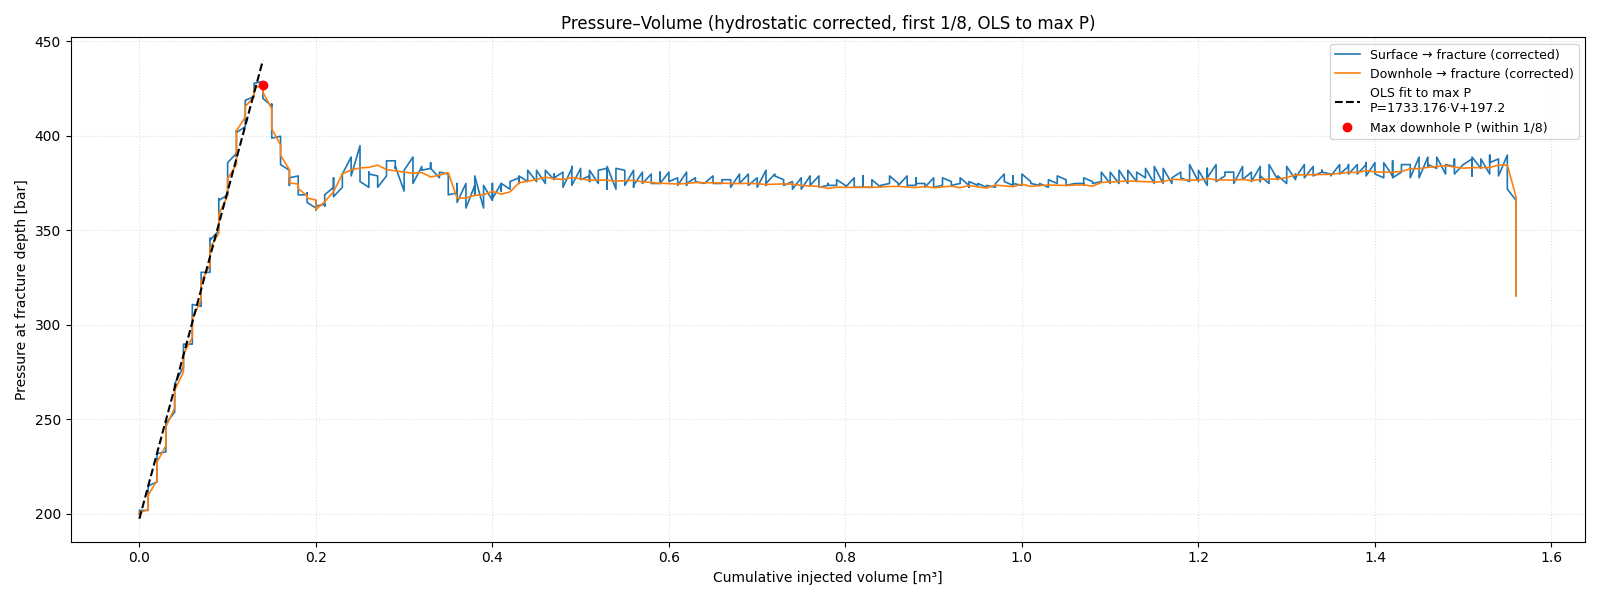

In [5]:
# ----------------------------
# Pressure vs Volume (hydrostatic corrected, first 1/8 only)
# OLS regression from start → max downhole pressure (within first 1/8)
# ----------------------------

# Interpolate surface volume onto downhole timebase
vol_interp = (
    pd.Series(volume_S.values, index=surface_dt_aligned_to_dh)
    .sort_index()
    .reindex(pd.to_datetime(downhole_dt_orig))
    .interpolate(method='time', limit_direction='both')
)

# --- Limit both datasets to first 1/8 ---
n_surf = max(2, len(volume_S) // 8)
n_down = max(2, len(vol_interp) // 8)

vol_s_subset = volume_S.iloc[:n_surf]
p_s_subset   = p_surface_corr[:n_surf]

vol_d_subset = vol_interp.iloc[:n_down]
p_d_subset   = p_downhole_corr[:n_down]

# --- Find index of maximum pressure within the 1/8 subset ---
idx_maxP = int(np.argmax(p_d_subset))

# Ensure we have at least 2 points for regression
if idx_maxP < 1:
    idx_maxP = min(1, len(p_d_subset) - 1)

vol_d_fit = vol_d_subset.iloc[:idx_maxP + 1]
p_d_fit   = p_d_subset[:idx_maxP + 1]

# --- Linear regression (ordinary least squares, not anchored) ---
coeffs = np.polyfit(vol_d_fit, p_d_fit, 1)
slope, intercept = coeffs     # slope = dP/dV  [bar/m³]
p_fit_line = np.poly1d(coeffs)

# --- Compliance (inverse of slope) ---
if slope != 0:
    C_m3_per_bar = 1.0 / slope              # [m³/bar]
    C_L_per_bar  = C_m3_per_bar * 1e3       # [L/bar]
else:
    C_m3_per_bar = np.nan
    C_L_per_bar  = np.nan

print(f"Linear fit (first 1/8, start → max P):  P = {slope:.4f}·V + {intercept:.2f}")
print(f"Slope = {slope:.4f} bar/m³")
print(f"Compliance = {C_m3_per_bar:.6f} m³/bar  ({C_L_per_bar:.2f} L/bar)")

# --- Plot ---
figP, axP = plt.subplots(figsize=(16, 6))

# Data (first 1/8 only)
axP.plot(vol_s_subset, p_s_subset, color='tab:blue', linewidth=1.2,
         label='Surface → fracture (corrected)')
axP.plot(vol_d_subset, p_d_subset, color='tab:orange', linewidth=1.2,
         label='Downhole → fracture (corrected)')

# Regression line (OLS fit to max P)
axP.plot(vol_d_fit, p_fit_line(vol_d_fit), 'k--', linewidth=1.5,
         label=f'OLS fit to max P\nP={slope:.3f}·V+{intercept:.1f}')

# Mark max pressure point within 1/8 subset
axP.plot(vol_d_subset.iloc[idx_maxP], p_d_subset.iloc[idx_maxP],
         'ro', label='Max downhole P (within 1/8)')

# Styling consistent with your other figures
axP.set_xlabel('Cumulative injected volume [m³]', fontsize=10)
axP.set_ylabel('Pressure at fracture depth [bar]', fontsize=10)
axP.set_title('Pressure–Volume (hydrostatic corrected, first 1/8, OLS to max P)', fontsize=12)
axP.grid(True, which='both', linestyle=':', alpha=0.4)
axP.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

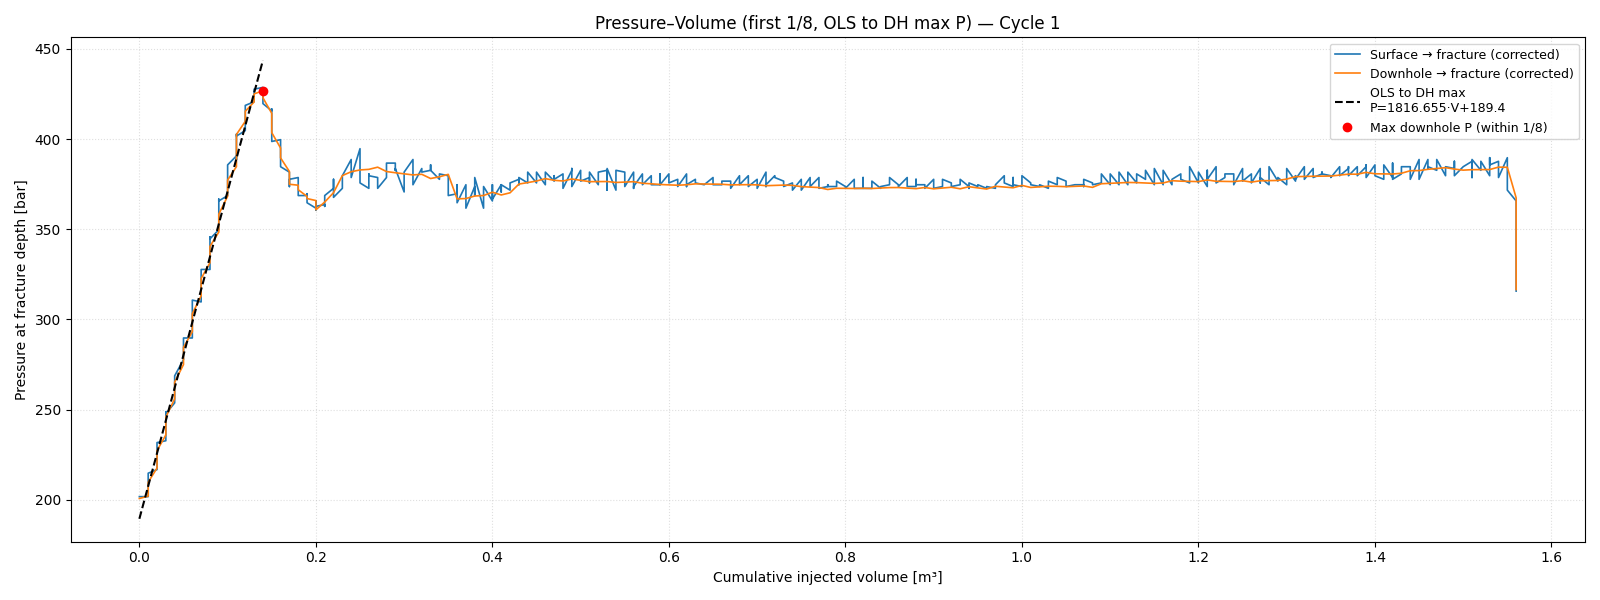

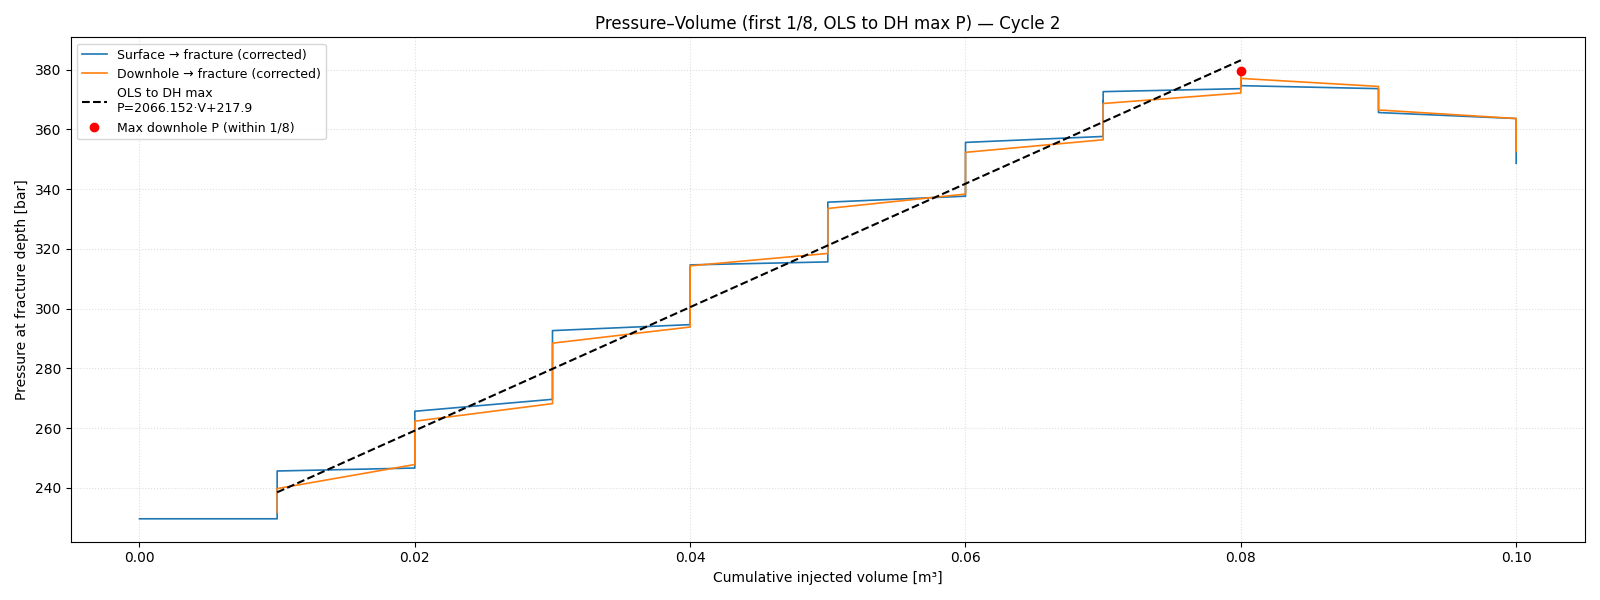

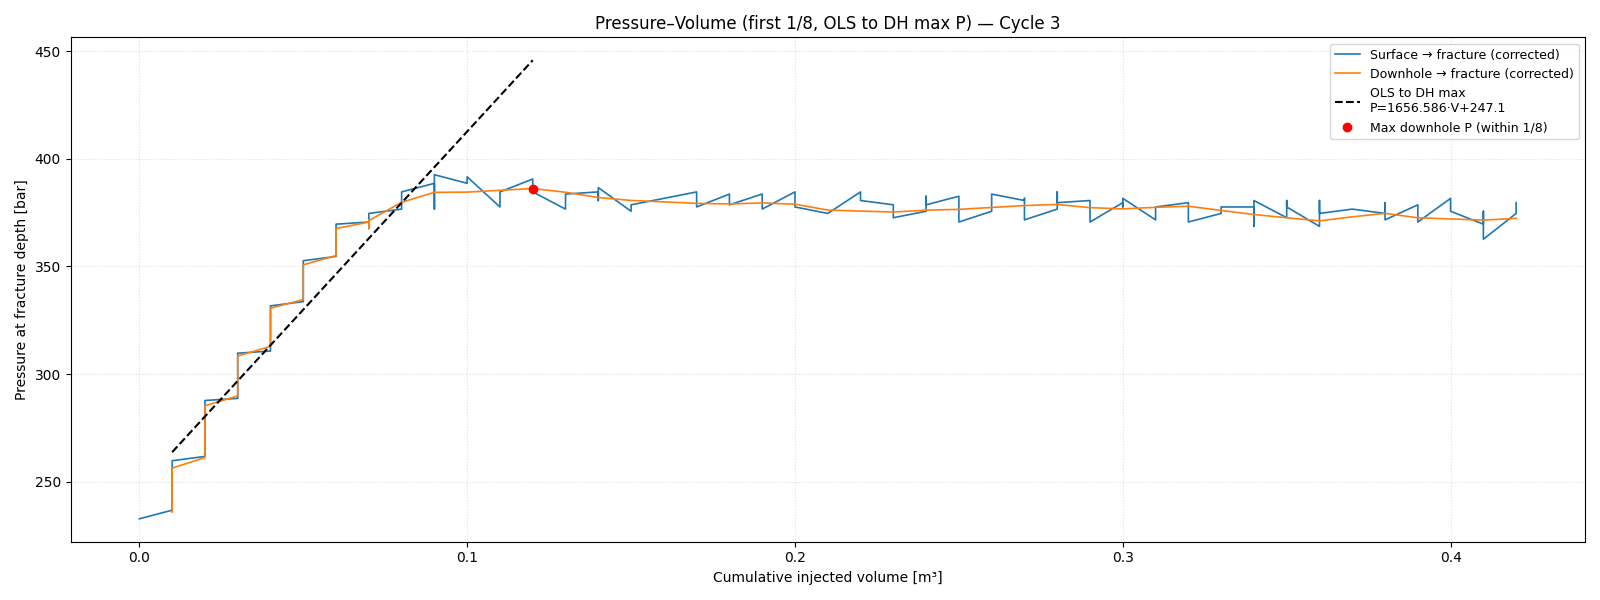

cycle  t_start  t_end  dh_maxP_bar_first_1_8  dh_vol_at_maxP_m3_first_1_8  \
0      1     2090   7241             426.813911                         0.14   
1      2     7334   8336             379.640239                         0.08   
2      3     8414  10032             386.251210                         0.12   

   ols_slope_bar_per_m3  ols_intercept_bar  compliance_m3_per_bar  \
0           1816.655239         189.380520               0.000550   
1           2066.152082         217.882727               0.000484   
2           1656.586489         247.098586               0.000604   

   compliance_L_per_bar  n_surf_subset  n_down_subset  
0              0.550462            643            214  
1              0.483991            125             41  
2              0.603651            202             67

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_first_eighth_ols_per_cycle(
    *,
    time_S,                # surface timestamps (array-like)
    volume_S,              # surface cumulative volume [m^3] (array-like)
    p_surface_corr,        # surface pressure [bar] (array-like)
    time_D,                # downhole timestamps (array-like)
    p_downhole_corr,       # downhole pressure [bar] (array-like)
    df_cycles,             # must have start_idx, end_idx (positional)
    surface_dt_aligned_to_dh=None,  # OPTIONAL: surface timestamps already aligned to DH clock
    lag_s=None,                        # OPTIONAL: shift surface timestamps by +lag_s seconds
    title_prefix="Pressure–Volume (first 1/8, OLS to DH max P)",
    min_pts=2,                         # minimum points for plotting/fitting
    verbose=False
):
    """
    For each cycle (i0..i1 on surface arrays):
      1) Build SURFACE slices: volume & pressure, and the corresponding time window.
      2) Map SURFACE volume onto the DOWNHOLE timebase (like your working snippet).
      3) Within the cycle's time window, take the first 1/8 of samples for both curves.
      4) Regress (OLS) from start → DH max-P index (within that subset).
      5) Plot Surface PV (blue), Downhole PV (orange), OLS line, and DH max-P marker.

    Returns a DataFrame with per-cycle slope, intercept, and compliance (m^3/bar and L/bar).
    """

    def _polyfit_safe(x, y):
        """Return slope, intercept or (np.nan, np.nan) if unfit (e.g., <2 distinct x)."""
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)
        # drop NaNs
        m = np.isfinite(x) & np.isfinite(y)
        x, y = x[m], y[m]
        if len(x) < 2:
            return np.nan, np.nan
        # require at least two distinct x values
        if np.allclose(np.nanmax(x), np.nanmin(x)):
            return np.nan, np.nan
        try:
            slope, intercept = np.polyfit(x, y, 1)
            return float(slope), float(intercept)
        except Exception:
            return np.nan, np.nan

    # --- Prepare time indices ---
    tS = pd.to_datetime(time_S)
    tD = pd.to_datetime(time_D)

    # Choose the surface timestamps to align to DH clock
    if surface_dt_aligned_to_dh is not None:
        tS_for_dh = pd.to_datetime(surface_dt_aligned_to_dh)
    elif lag_s is not None:
        tS_for_dh = tS + pd.to_timedelta(float(lag_s), unit="s")
    else:
        # fallback: assume clocks already aligned
        tS_for_dh = tS

    # Build time-indexed series (global)
    V_S_time = pd.Series(np.asarray(volume_S, dtype=float), index=tS_for_dh).sort_index()
    P_D_time = pd.Series(np.asarray(p_downhole_corr, dtype=float), index=tD).sort_index()

    # Precompute SURFACE volume on the DOWNHOLE timebase (global, as you did)
    V_on_D_all = (
        V_S_time
        .reindex(P_D_time.index)
        .interpolate(method="time", limit_direction="both")
    )

    # Positional (do NOT sort) for cycle slicing
    V_pos = pd.Series(np.asarray(volume_S, dtype=float))
    Ps_pos = pd.Series(np.asarray(p_surface_corr, dtype=float))
    Ts_pos = pd.Series(pd.to_datetime(time_S))

    out_rows = []
    if len(df_cycles) == 0:
        print("No cycles detected.")
        return pd.DataFrame(out_rows)

    for n, row in enumerate(df_cycles.itertuples(index=False), start=1):
        i0, i1 = int(row.start_idx), int(row.end_idx)
        if i1 <= i0 or i0 < 0 or i1 >= len(V_pos):
            if verbose: print(f"[cycle {n}] skip: invalid idx {i0}-{i1}")
            continue

        # -------- SURFACE (positional slice) --------
        Vw = V_pos.iloc[i0:i1+1]
        Pw = Ps_pos.iloc[i0:i1+1]
        Tw = Ts_pos.iloc[i0:i1+1]          # original surface time window (for masking DH)

        if len(Vw) < min_pts:
            if verbose: print(f"[cycle {n}] surface window < {min_pts} points")
            continue

        # Define cycle time window in the *aligned* surface clock used for DH mapping
        if surface_dt_aligned_to_dh is not None:
            Tw_for_dh = pd.to_datetime(surface_dt_aligned_to_dh[i0:i1+1])
        elif lag_s is not None:
            Tw_for_dh = pd.to_datetime(Tw) + pd.to_timedelta(float(lag_s), unit="s")
        else:
            Tw_for_dh = pd.to_datetime(Tw)

        t0, t1 = Tw_for_dh.iloc[0], Tw_for_dh.iloc[-1]
        if pd.isna(t0) or pd.isna(t1) or t1 <= t0:
            if verbose: print(f"[cycle {n}] skip: bad time window")
            continue

        # -------- DOWNHOLE slice by time overlap --------
        mask_D = (P_D_time.index >= t0) & (P_D_time.index <= t1)
        if not mask_D.any():
            if verbose: print(f"[cycle {n}] no DH overlap in [{t0} .. {t1}]")
            continue

        # SURFACE volume on DH timestamps within this window, and DH pressure
        vol_d_cycle = V_on_D_all.loc[mask_D]
        p_d_cycle   = P_D_time.loc[mask_D]

        # Basic sanity: drop NaN pairs on DH curve
        mD = np.isfinite(vol_d_cycle.values) & np.isfinite(p_d_cycle.values)
        vol_d_cycle = vol_d_cycle.iloc[mD]
        p_d_cycle   = p_d_cycle.iloc[mD]

        if len(vol_d_cycle) < min_pts:
            if verbose: print(f"[cycle {n}] DH segment < {min_pts} points after cleaning")
            continue

        # -------- First 1/8 subsets (per your snippet) --------
        n_surf = max(min_pts, len(Vw) // 8)
        n_down = max(min_pts, len(vol_d_cycle) // 8)

        vol_s_subset = Vw.iloc[:n_surf]
        p_s_subset   = Pw.iloc[:n_surf]

        vol_d_subset = vol_d_cycle.iloc[:n_down]
        p_d_subset   = p_d_cycle.iloc[:n_down]

        # Guard: drop NaN pairs in surface subset
        mS = np.isfinite(vol_s_subset.values) & np.isfinite(p_s_subset.values)
        vol_s_subset = vol_s_subset.iloc[mS]
        p_s_subset   = p_s_subset.iloc[mS]

        # Need at least 2 points to draw/fit
        if len(vol_s_subset) < min_pts or len(vol_d_subset) < min_pts:
            if verbose: print(f"[cycle {n}] subset too small (S={len(vol_s_subset)}, D={len(vol_d_subset)})")
            continue

        # --- Find index of maximum downhole pressure within the 1/8 subset ---
        try:
            idx_maxP = int(np.nanargmax(p_d_subset.values))
        except ValueError:
            if verbose: print(f"[cycle {n}] no finite values for DH max")
            continue

        if idx_maxP < 1:
            idx_maxP = min(1, len(p_d_subset) - 1)

        vol_d_fit = vol_d_subset.iloc[:idx_maxP + 1]
        p_d_fit   = p_d_subset.iloc[:idx_maxP + 1]

        # --- Linear regression (OLS) on DH subset up to its max P ---
        slope, intercept = _polyfit_safe(vol_d_fit.values, p_d_fit.values)

        # --- Compliance (from DH slope) ---
        if np.isfinite(slope) and slope != 0.0:
            C_m3_per_bar = 1.0 / slope
            C_L_per_bar  = C_m3_per_bar * 1e3
        else:
            C_m3_per_bar = np.nan
            C_L_per_bar  = np.nan

        # --- Plot ---
        figP, axP = plt.subplots(figsize=(16, 6))

        # Surface curve (first 1/8)
        axP.plot(vol_s_subset, p_s_subset, color='tab:blue', linewidth=1.2,
                 label='Surface → fracture (corrected)')

        # Downhole curve (first 1/8)
        axP.plot(vol_d_subset, p_d_subset, color='tab:orange', linewidth=1.2,
                 label='Downhole → fracture (corrected)')

        # OLS line to DH max within first 1/8
        if np.isfinite(slope) and np.isfinite(intercept) and len(vol_d_fit) >= 2:
            axP.plot(vol_d_fit, slope * vol_d_fit + intercept, 'k--', linewidth=1.5,
                     label=f'OLS to DH max\nP={slope:.3f}·V+{intercept:.1f}')
        else:
            if verbose: print(f"[cycle {n}] OLS skipped (insufficient or ill-conditioned data)")

        # Mark DH max pressure point (within first 1/8)
        axP.plot(vol_d_subset.iloc[idx_maxP], p_d_subset.iloc[idx_maxP],
                 'ro', label='Max downhole P (within 1/8)')

        axP.set_xlabel('Cumulative injected volume [m³]', fontsize=10)
        axP.set_ylabel('Pressure at fracture depth [bar]', fontsize=10)
        axP.set_title(f'{title_prefix} — Cycle {n}', fontsize=12)
        axP.grid(True, which='both', linestyle=':', alpha=0.4)
        axP.legend(loc='best', fontsize=9)

        plt.tight_layout()
        plt.show()

        out_rows.append({
            "cycle": n,
            "t_start": getattr(row, 't_start', None),
            "t_end": getattr(row, 't_end', None),
            "dh_maxP_bar_first_1_8": float(p_d_subset.iloc[idx_maxP]),
            "dh_vol_at_maxP_m3_first_1_8": float(vol_d_subset.iloc[idx_maxP]),
            "ols_slope_bar_per_m3": slope,
            "ols_intercept_bar": intercept,
            "compliance_m3_per_bar": C_m3_per_bar,
            "compliance_L_per_bar": C_L_per_bar,
            "n_surf_subset": int(len(vol_s_subset)),
            "n_down_subset": int(len(vol_d_subset)),
        })

    return pd.DataFrame(out_rows)

df = plot_first_eighth_ols_per_cycle(
    time_S=time_S,
    volume_S=volume_S,
    p_surface_corr=p_surface_corr,
    time_D=downhole_dt_orig,
    p_downhole_corr=p_downhole_corr,
    df_cycles=df_cycles,                       # needs start_idx, end_idx
    surface_dt_aligned_to_dh=surface_dt_aligned_to_dh,  # or use lag_s=... if you prefer
    verbose=False
)
display(df)

C_well ≈ 0.55 L/bar


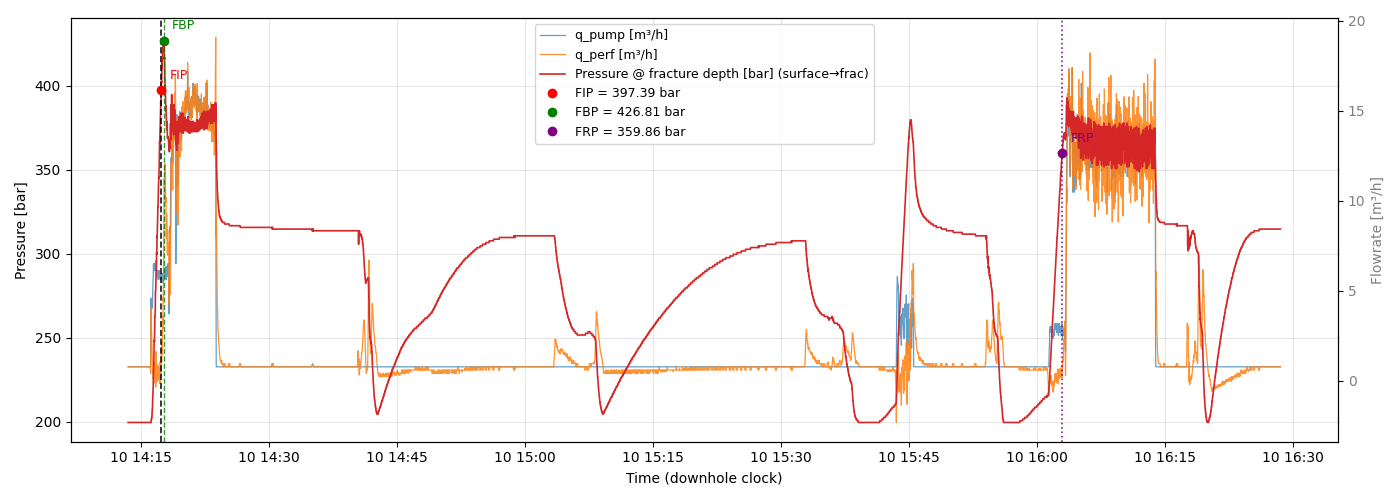

FIP: 397.39 bar at 2023-12-10 14:17:22
FBP: 426.81 bar at 2023-12-10 14:17:39
FRP: 359.86 bar at 2023-12-10 16:02:55


In [7]:
# ----------------------------
# Hydrostatic-corrected PV analysis (surface gauge → fracture)
# Plot on DOWNHOLE clock; draw FIP and get DH pressure at FIP & FBP
# ----------------------------


# --- Helpers ---
def _combine_legend(ax1, ax2):
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="best")

def _interp_time(series_dt: pd.Series, t_query: pd.Timestamp) -> tuple[pd.Timestamp, float]:
    """Time-interpolate a datetime-indexed numeric Series at t_query.
       Clips to bounds; falls back to nearest if interpolation fails."""
    s = series_dt.sort_index()
    s = s[~s.index.duplicated(keep="first")].interpolate(method="time", limit_direction="both")
    t_min, t_max = s.index.min(), s.index.max()
    t_q = min(max(pd.Timestamp(t_query), t_min), t_max)
    try:
        val = s.reindex(s.index.union([t_q])).interpolate(method="time").loc[t_q]
        val = float(val)
    except Exception:
        i = np.argmin(np.abs(s.index.values.astype("datetime64[ns]") - np.datetime64(t_q)))
        t_q = s.index[i]
        val = float(s.iloc[i])
    return t_q, val

# --- Lag (s) to align surface -> downhole clock ---
try:
    lag_seconds = float(lag_s)
except Exception:
    lag_seconds = 0.0

# --- Build aligned surface frame (already hydrostatically corrected to fracture) ---
df = pd.DataFrame({
    "time_surface": pd.to_datetime(time_S),
    "P_frac_bar":   pd.to_numeric(np.asarray(p_surface_corr), errors="coerce"),
    "V_m3":         pd.to_numeric(np.asarray(volume_S),       errors="coerce"),
    "q_m3h":        pd.to_numeric(np.asarray(flowrate_S),     errors="coerce"),
}).dropna().sort_values("time_surface", kind="mergesort").reset_index(drop=True)

time_s_dh  = df["time_surface"] - pd.to_timedelta(lag_seconds, unit="s")
P          = df["P_frac_bar"].to_numpy()
V          = df["V_m3"].to_numpy()
q_pump_m3h = df["q_m3h"].to_numpy()

# --- Early PV slope (optional diagnostic) ---
i0, i1 = 200, 600
C_well = np.polyfit(P[i0:i1], V[i0:i1], 1)[0]  # dV/dP [m³/bar]
# Or override with your own value:
C_well = 0.00055
print(f"C_well ≈ {C_well*1e3:.2f} L/bar")

# --- q_perf = q_pump - C_well * dP/dt (compute dP/dt on DH clock) ---
ts       = (time_s_dh - time_s_dh.iloc[0]).dt.total_seconds().to_numpy()
P_smooth = pd.Series(P, index=time_s_dh).rolling("10s", center=True, min_periods=1).mean().to_numpy()
dPdt     = np.gradient(P_smooth, ts)                     # [bar/s]
q_perf_m3h = (q_pump_m3h / 3600.0 - C_well * dPdt) * 3600.0  # [m³/h]

# --- Plot on DOWNHOLE clock (Pressure on top, then q_perf, then q_pump) ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# Normalize flowrates onto the pressure axis so z-order actually works
q_min = np.nanmin([np.nanmin(q_pump_m3h), np.nanmin(q_perf_m3h)])
q_max = np.nanmax([np.nanmax(q_pump_m3h), np.nanmax(q_perf_m3h)])
q_range = (q_max - q_min) if q_max != q_min else 1.0
P_min, P_max = np.nanmin(P), np.nanmax(P)
P_range = (P_max - P_min) if P_max != P_min else 1.0

q_pump_scaled = (q_pump_m3h - q_min) / q_range * P_range + P_min
q_perf_scaled = (q_perf_m3h - q_min) / q_range * P_range + P_min

# Draw order: bottom → top
# 1) q_pump (blue) bottom
ax1.plot(time_s_dh, q_pump_scaled, color="C0", lw=0.9, alpha=0.7, zorder=1, label="q_pump [m³/h]")

# 2) q_perf (yellow) middle
ax1.plot(time_s_dh, q_perf_scaled, color="C1", lw=0.9, alpha=0.85, zorder=2, label="q_perf [m³/h]")

# 3) Pressure (red) top
ax1.plot(time_s_dh, P, color="C3", lw=1.2, zorder=3,
         label="Pressure @ fracture depth [bar] (surface→frac)")

ax1.set_ylabel("Pressure [bar]")
ax1.set_xlabel("Time (downhole clock)")
ax1.grid(True, alpha=0.3)

# Secondary y-axis with actual flow units (visual aid only)
ax2 = ax1.twinx()
ax2.set_ylim(q_min, q_max)
ax2.set_ylabel("Flowrate [m³/h]", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

# --- Time picks: FIP / FBP / FRP ---
t_FIP_dh = pd.Timestamp("2023-12-10 14:17:22")   # set yours
t_FRP_dh = pd.Timestamp("2023-12-10 16:02:55")   # hand-pick as needed

p_dh_series = pd.Series(
    pd.to_numeric(np.asarray(p_downhole_corr), errors="coerce"),
    index=pd.to_datetime(downhole_dt_orig)
).sort_index()

# Safe interpolation at picks
t_FIP_q, P_FIP = _interp_time(p_dh_series, t_FIP_dh)
FBP_bar        = float(p_dh_series.max()); t_FBP = p_dh_series.idxmax()
t_FRP_q, P_FRP = _interp_time(p_dh_series, t_FRP_dh)

# Vertical lines
ax1.axvline(t_FIP_q, color="k", linestyle="--", lw=1.2, alpha=0.9, zorder=4)
ax1.axvline(t_FBP,   color="g", linestyle="--", lw=1.0, alpha=0.8, zorder=4)
ax1.axvline(t_FRP_q, color="purple", linestyle=":", lw=1.2, alpha=0.9, zorder=4)

# Dots (all three) + text labels
ax1.plot(t_FIP_q, P_FIP,  "o", ms=6, color="r",      zorder=5, label=f"FIP = {P_FIP:.2f} bar")
ax1.plot(t_FBP,   FBP_bar,"o", ms=6, color="g",      zorder=5, label=f"FBP = {FBP_bar:.2f} bar")
ax1.plot(t_FRP_q, P_FRP,  "o", ms=6, color="purple", zorder=5, label=f"FRP = {P_FRP:.2f} bar")

# Place short text tags next to each dot (kept simple & readable)
ax1.annotate("FIP", xy=(t_FIP_q, P_FIP),  xytext=(6, 8), textcoords="offset points",
             color="r", fontsize=9, zorder=6)
ax1.annotate("FBP", xy=(t_FBP,   FBP_bar),xytext=(6, 8), textcoords="offset points",
             color="g", fontsize=9, zorder=6)
ax1.annotate("FRP", xy=(t_FRP_q, P_FRP),  xytext=(6, 8), textcoords="offset points",
             color="purple", fontsize=9, zorder=6)

# Legend & layout
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, l, loc="best", fontsize=9)
plt.tight_layout()
plt.show()

# Console printouts (optional)
print(f"FIP: {P_FIP:.2f} bar at {t_FIP_q}")
print(f"FBP: {FBP_bar:.2f} bar at {t_FBP}")
print(f"FRP: {P_FRP:.2f} bar at {t_FRP_q}")

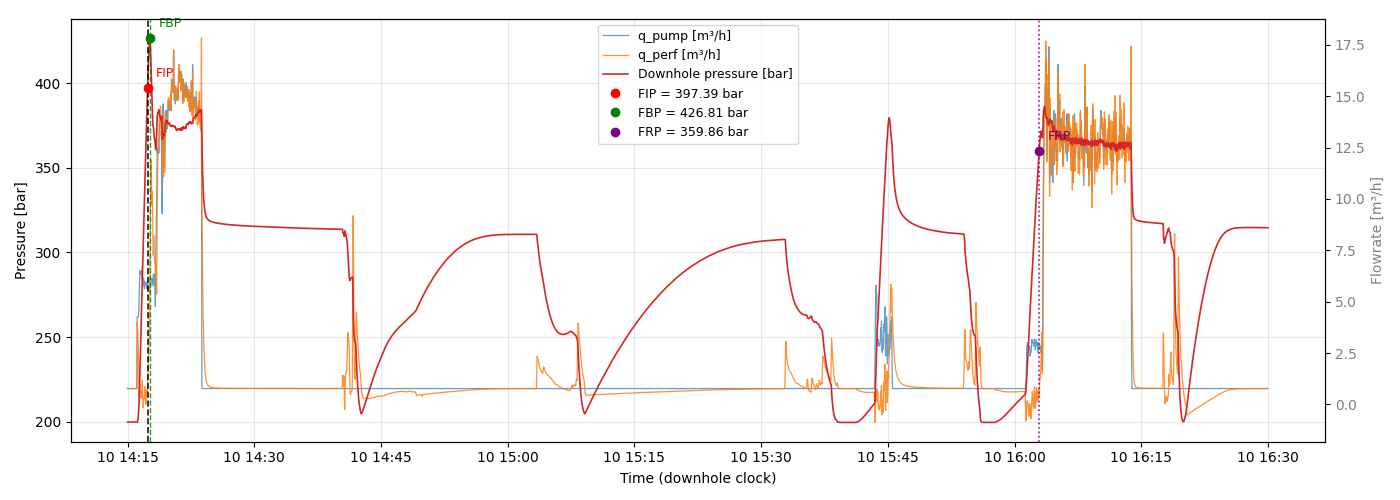

FIP: 397.39 bar at 2023-12-10 14:17:22
FBP: 426.81 bar at 2023-12-10 14:17:39
FRP: 359.86 bar at 2023-12-10 16:02:55


In [8]:
# ----------------------------
# Plot using DOWNHOLE pressure for everything (NO SMOOTHING)
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Downhole time & pressure (x-axis + red curve) ---
t_dh = pd.to_datetime(downhole_dt_orig)
P_dh = pd.to_numeric(np.asarray(p_downhole_corr), errors="coerce")
P_dh_series = pd.Series(P_dh, index=t_dh).sort_index()

# --- Surface flow on the downhole clock ---
# shift surface time onto DH clock (same lag you used before)
try:
    lag_seconds = float(lag_s)
except Exception:
    lag_seconds = 0.0

tS_aligned = pd.to_datetime(time_S) - pd.to_timedelta(lag_seconds, unit="s")
q_pump_series = pd.Series(pd.to_numeric(np.asarray(flowrate_S), errors="coerce"),
                          index=tS_aligned).sort_index()

# Reindex q_pump to DH timestamps (time interpolation)
q_pump_on_dh = (q_pump_series
                .reindex(P_dh_series.index)
                .interpolate(method="time", limit_direction="both"))

# --- Compliance (wellbore/system) ---
C_well = 0.00055  # m³/bar

# --- dP/dt from RAW DOWNHOLE pressure ---
ts = (P_dh_series.index - P_dh_series.index[0]).total_seconds().to_numpy()
dPdt_dh = np.gradient(P_dh_series.to_numpy(), ts)  # bar/s (no smoothing!)

# --- q_perf on the downhole clock ---
# q_perf = q_pump - C_well * dP/dt   (careful with units)
q_perf_on_dh_m3h = (q_pump_on_dh.to_numpy() / 3600.0 - C_well * dPdt_dh) * 3600.0

# --- Scale flows to the pressure axis so z-order works cleanly ---
q_all = np.concatenate([q_pump_on_dh.to_numpy(), q_perf_on_dh_m3h])
q_min = np.nanmin(q_all); q_max = np.nanmax(q_all)
if not np.isfinite(q_min) or not np.isfinite(q_max) or q_max == q_min:
    q_min, q_max = 0.0, 1.0
q_range = q_max - q_min

P_min = np.nanmin(P_dh_series); P_max = np.nanmax(P_dh_series)
if not np.isfinite(P_min) or not np.isfinite(P_max) or P_max == P_min:
    P_min, P_max = 0.0, 1.0
P_range = P_max - P_min

q_pump_scaled = (q_pump_on_dh.to_numpy() - q_min) / q_range * P_range + P_min
q_perf_scaled = (q_perf_on_dh_m3h - q_min) / q_range * P_range + P_min

# --- Helper: safe time interpolation on DH series ---
def _interp_time(series_dt: pd.Series, t_query: pd.Timestamp):
    s = series_dt.sort_index()
    s = s[~s.index.duplicated(keep="first")].interpolate(method="time", limit_direction="both")
    t_min, t_max = s.index.min(), s.index.max()
    t_q = min(max(pd.Timestamp(t_query), t_min), t_max)
    val = s.reindex(s.index.union([t_q])).interpolate(method="time").loc[t_q]
    return t_q, float(val)

# --- Picks on the DOWNHOLE clock ---
t_FIP_dh = pd.Timestamp("2023-12-10 14:17:22")   # set yours
t_FRP_dh = pd.Timestamp("2023-12-10 16:02:55")   # hand-pick as needed

t_FIP_q, P_FIP = _interp_time(P_dh_series, t_FIP_dh)
FBP_bar = float(P_dh_series.max()); t_FBP = P_dh_series.idxmax()
t_FRP_q, P_FRP = _interp_time(P_dh_series, t_FRP_dh)

# --- Plot (single axis; enforce stacking) ---
fig, ax1 = plt.subplots(figsize=(14, 5))

# bottom → top
ax1.plot(t_dh, q_pump_scaled, color="C0", lw=0.9, alpha=0.7, zorder=1, label="q_pump [m³/h]")
ax1.plot(t_dh, q_perf_scaled, color="C1", lw=0.9, alpha=0.85, zorder=2, label="q_perf [m³/h]")
ax1.plot(t_dh, P_dh_series, color="C3", lw=1.2, zorder=3, label="Downhole pressure [bar]")

ax1.set_xlabel("Time (downhole clock)")
ax1.set_ylabel("Pressure [bar]")
ax1.grid(True, alpha=0.3)

# Secondary y-axis to display real flow units
ax2 = ax1.twinx()
ax2.set_ylim(q_min, q_max)
ax2.set_ylabel("Flowrate [m³/h]", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

# Vertical lines
ax1.axvline(t_FIP_q, color="k", linestyle="--", lw=1.2, alpha=0.9, zorder=4)
ax1.axvline(t_FBP,   color="g", linestyle="--", lw=1.0, alpha=0.8, zorder=4)
ax1.axvline(t_FRP_q, color="purple", linestyle=":",  lw=1.2, alpha=0.9, zorder=4)

# Dots + short labels
ax1.plot(t_FIP_q, P_FIP,   "o", ms=6, color="r",      zorder=5, label=f"FIP = {P_FIP:.2f} bar")
ax1.plot(t_FBP,   FBP_bar, "o", ms=6, color="g",      zorder=5, label=f"FBP = {FBP_bar:.2f} bar")
ax1.plot(t_FRP_q, P_FRP,   "o", ms=6, color="purple", zorder=5, label=f"FRP = {P_FRP:.2f} bar")

# Text tags
ax1.annotate("FIP", xy=(t_FIP_q, P_FIP),   xytext=(6, 8), textcoords="offset points",
             color="r", fontsize=9, zorder=6)
ax1.annotate("FBP", xy=(t_FBP,   FBP_bar), xytext=(6, 8), textcoords="offset points",
             color="g", fontsize=9, zorder=6)
ax1.annotate("FRP", xy=(t_FRP_q, P_FRP),   xytext=(6, 8), textcoords="offset points",
             color="purple", fontsize=9, zorder=6)

# Legend & layout
h, l = ax1.get_legend_handles_labels()
ax1.legend(h, l, loc="best", fontsize=9)
plt.tight_layout()
plt.show()

# Console readout
print(f"FIP: {P_FIP:.2f} bar at {t_FIP_q}")
print(f"FBP: {FBP_bar:.2f} bar at {t_FBP}")
print(f"FRP: {P_FRP:.2f} bar at {t_FRP_q}")

In [9]:
# ----------------------------
# MULTI-CYCLE: detect all pump-in → 
# 
# cycles (surface clock)
# and cut each falloff at (pump restart | flow-back start | end of data)
# ----------------------------
q_low, q_high = closure_analysis.suggest_flow_thresholds(flowrate_S)

#cycles = closure_analysis.detect_pump_cycles(
#    time_S=time_S,
#    q_m3h=flowrate_S,
#    return_vol_S=return_volume_S,   # pass None if not available
#    q_low=0.1, q_high=0.3,
#    min_hold_s=30,
#    min_gap_s=60,
#    flowback_rate_thresh=0.2
#)

cycles = closure_analysis.detect_pump_cycles(
    time_S, flowrate_S, return_volume_S,
    q_low=0.1, q_high=0.3,
    manual_shutins_surface=MANUAL_SHUTINS_SURFACE,
    manual_tolerance_s=90,
    prefer_manual=True
)
print(f"Detected {len(cycles)} cycles.")

df_cycles = closure_analysis.analyze_all_shutins(
    cycles,
    time_S=time_S, flowrate_S=flowrate_S, return_volume_S=return_volume_S,
    time_D=time_D, p_downhole_corr=p_downhole_corr,
    lag_s=lag_s,
    min_falloff_s=10,
    min_t_s_for_pick=0,
    max_analysis_s=180,
    pick_from="sqrt",
    manual_shutins_surface=MANUAL_SHUTINS_SURFACE,  # list[str or Timestamp]
    manual_tolerance_s=90,   # cycle’s t_shut must be within 90 s of a manual to be replaced
    prefer_manual=True
)

print("\nSummary table:")
print(df_cycles)

out_path = Path("per_cycle_closure.csv")
#df_cycles.to_csv(out_path, index=False)
print(f"Saved per-cycle results to: {out_path.resolve()}")

for k, c in enumerate(cycles, 1):
    print(f"Cycle {k}: start={c['t_pump_start_surface']}, "
          f"shut={c['t_shut_in_surface']}, end={c['t_end_surface']}, "
          f"ended_by={c['ended_by']}")

Detected 0 cycles.

Summary table:
Empty DataFrame
Columns: []
Index: []
Saved per-cycle results to: /Users/william/Desktop/Thesis-AES/per_cycle_closure.csv


In [10]:
import numpy as np
import pandas as pd

def detect_pump_cycles_with_manual(
    time_S: pd.Series,
    q_m3h: pd.Series,
    return_vol_S: pd.Series | None = None,
    *,
    q_low=0.1, q_high=0.3,
    min_hold_s=30,
    min_gap_s=60,
    flowback_rate_thresh=0.2,
    manual_shutins_surface=None,
    manual_tolerance_s=90,
    prefer_manual=True,
    verbose=True,
):
    """
    Detect cycles from flow, then overlay/augment with manual shut-ins.
    If autos fail, create cycles from manual times by searching for a plausible pump start
    and an end (restart/flowback/end-of-data).
    """
    t = pd.to_datetime(pd.Series(time_S))
    q = pd.Series(q_m3h, dtype=float)
    if len(t) != len(q):
        raise ValueError("time_S and q_m3h lengths differ")

    # Basic stats (diagnostics)
    if verbose:
        print(f"[detect] time range: {t.min()} → {t.max()}")
        print(f"[detect] q stats (m³/h): min={np.nanmin(q):.4g}, max={np.nanmax(q):.4g}, "
              f"mean={np.nanmean(q):.4g}, >q_high fraction={(q>q_high).mean():.2%}")

    # Optional flowback rate from return volume
    rv_rate = None
    if return_vol_S is not None and return_vol_S.notna().any():
        rv = pd.Series(return_vol_S.values, index=t).sort_index()
        # simple centered difference per hour
        drv = rv.diff().fillna(0.0) * (3600.0 / np.maximum(1e-9, (t.view('i8').to_numpy() - np.roll(t.view('i8').to_numpy(),1))/1e9))
        drv.iloc[0] = 0.0
        rv_rate = drv

    # ---------- pass 1: auto cycles (finite-state with hysteresis) ----------
    cycles_auto = []
    state = 'idle'
    t_pump_start = None
    last_end_t = None
    t_list = t.tolist()
    q_list = q.fillna(-np.inf).tolist()

    for i in range(len(t)):
        ti, qi = t_list[i], q_list[i]
        if not np.isfinite(qi):
            continue

        fb_on = False
        if rv_rate is not None and np.isfinite(rv_rate.iloc[i]):
            fb_on = (qi <= q_low) and (rv_rate.iloc[i] > flowback_rate_thresh)

        if state == 'idle':
            gap_ok = True if last_end_t is None else (ti - last_end_t).total_seconds() >= min_gap_s
            if qi >= q_high and gap_ok:
                t_pump_start = ti
                state = 'pumping'

        elif state == 'pumping':
            if qi <= q_low:
                # must hold low for min_hold_s
                j, ok = i, True
                while j < len(t) and (t_list[j] - ti).total_seconds() <= min_hold_s:
                    if np.isfinite(q_list[j]) and q_list[j] > q_low:
                        ok = False; break
                    j += 1
                if ok:
                    t_shut = ti
                    state = 'shutin'

        if state == 'shutin':
            if fb_on:
                cycles_auto.append(dict(
                    t_pump_start_surface=t_pump_start,
                    t_shut_in_surface=t_shut,
                    t_end_surface=ti,
                    ended_by='flowback'
                ))
                last_end_t = ti
                state = 'idle'
                t_pump_start = None
                continue
            if qi >= q_high:
                cycles_auto.append(dict(
                    t_pump_start_surface=t_pump_start,
                    t_shut_in_surface=t_shut,
                    t_end_surface=ti,
                    ended_by='restart'
                ))
                last_end_t = ti
                state = 'pumping'
                t_pump_start = ti
                continue

    if state == 'shutin':
        end_t = t.iloc[-1]
        cycles_auto.append(dict(
            t_pump_start_surface=t_pump_start,
            t_shut_in_surface=t_shut,
            t_end_surface=end_t,
            ended_by='end'
        ))

    # ---------- pass 2: overlay/augment with manual shut-ins ----------
    manuals = pd.DatetimeIndex(pd.to_datetime(manual_shutins_surface)) if manual_shutins_surface else pd.DatetimeIndex([])
    tol = pd.Timedelta(seconds=int(manual_tolerance_s))

    def _snap_to_nearest(sampled_times: pd.DatetimeIndex, target: pd.Timestamp):
        idx = int(np.argmin(np.abs(sampled_times.values - np.datetime64(target))))
        return sampled_times[idx]

    # index by shut-in for quick match
    auto_by_shut = {pd.Timestamp(c['t_shut_in_surface']): c for c in cycles_auto}

    # If prefer_manual: replace nearby autos; and add missing cycles from manuals
    cycles_out = []
    used_manuals = set()

    t_idx = pd.DatetimeIndex(t)

    for m in manuals:
        if not (t_idx.min() <= m <= t_idx.max()):
            if verbose:
                print(f"[manual] ignored (out of range): {m}")
            continue

        # Find existing auto within tolerance
        replacement = None
        for a_shut, c in list(auto_by_shut.items()):
            if abs(a_shut - m) <= tol:
                replacement = c
                break

        # Find a plausible pump start before m (search back for last time q >= q_high)
        j = int(np.searchsorted(t_idx.values, np.datetime64(m)))-1
        j0 = j
        t_pstart = None
        while j >= 0:
            if np.isfinite(q.iloc[j]) and q.iloc[j] >= q_high:
                # also require a preceding idle gap or a rise
                t_pstart = t.iloc[j]
                break
            j -= 1

        # Find end: first restart after m or end-of-data
        k = int(np.searchsorted(t_idx.values, np.datetime64(m)))
        t_end = t.iloc[-1]
        ended_by = 'end'
        while k < len(t):
            if np.isfinite(q.iloc[k]) and q.iloc[k] >= q_high:
                t_end = t.iloc[k]; ended_by = 'restart'; break
            # flowback heuristic
            if rv_rate is not None and (q.iloc[k] <= q_low) and (rv_rate.iloc[k] > flowback_rate_thresh):
                t_end = t.iloc[k]; ended_by = 'flowback'; break
            k += 1

        if replacement is not None:
            # replace shut-in with manual timestamp (keep start/end)
            c = replacement.copy()
            c['t_shut_in_surface'] = _snap_to_nearest(t_idx, m)
            cycles_out.append(c)
            used_manuals.add(m)
        else:
            # create new cycle from manual if we have a reasonable start
            if t_pstart is not None and (m - t_pstart) >= pd.Timedelta(seconds=min_hold_s):
                cycles_out.append(dict(
                    t_pump_start_surface=t_pstart,
                    t_shut_in_surface=_snap_to_nearest(t_idx, m),
                    t_end_surface=t_end,
                    ended_by=ended_by
                ))
                used_manuals.add(m)
            else:
                if verbose:
                    print(f"[manual] cannot form cycle at {m} "
                          f"(no valid pump start before manual or too short hold).")

    # Keep any autos that were not replaced (if not strictly prefer manual)
    if not prefer_manual:
        for c in cycles_auto:
            if not any(abs(pd.Timestamp(c['t_shut_in_surface']) - m) <= tol for m in used_manuals):
                cycles_out.append(c)
    else:
        # Prefer manual: still include autos that have no close manual
        for c in cycles_auto:
            if manuals.empty or not any(abs(pd.Timestamp(c['t_shut_in_surface']) - m) <= tol for m in manuals):
                cycles_out.append(c)

    # De-duplicate by (start, shut) pair
    uniq = {}
    for c in cycles_out:
        key = (pd.Timestamp(c['t_pump_start_surface']),
               pd.Timestamp(c['t_shut_in_surface']))
        uniq[key] = c
    cycles_out = list(uniq.values())

    # Final filter: duration check
    out = []
    for c in cycles_out:
        if (c['t_end_surface'] - c['t_shut_in_surface']).total_seconds() >= min_hold_s:
            out.append(c)
    if verbose:
        print(f"[detect] autos={len(cycles_auto)}, manuals={len(manuals)}, result={len(out)}")
    return out

cycles = detect_pump_cycles_with_manual(
    time_S=time_S,
    q_m3h=flowrate_S,
    return_vol_S=return_volume_S,
    q_low=0.1, q_high=0.3,           # adjust if your units are not m³/h
    min_hold_s=30,
    min_gap_s=60,
    flowback_rate_thresh=0.2,
    manual_shutins_surface=MANUAL_SHUTINS_SURFACE,
    manual_tolerance_s=90,
    prefer_manual=True,
    verbose=True
)
print(f"Detected {len(cycles)} cycles.")
for i,c in enumerate(cycles,1):
    print(f"  {i}: start={c['t_pump_start_surface']}, shut={c['t_shut_in_surface']}, "
          f"end={c['t_end_surface']}, ended_by={c['ended_by']}")
    

df_cycles = closure_analysis.analyze_all_shutins(
    cycles,
    time_S=time_S, flowrate_S=flowrate_S, return_volume_S=return_volume_S,
    time_D=time_D, p_downhole_corr=p_downhole_corr,
    lag_s=lag_s,
    min_falloff_s=10,
    min_t_s_for_pick=0,
    max_analysis_s=180,
    pick_from="sqrt"
)
print(df_cycles)




[detect] time range: 2023-12-10 15:15:00 → 2023-12-10 17:30:00
[detect] q stats (m³/h): min=0, max=18.3, mean=1.797, >q_high fraction=16.44%
[detect] autos=3, manuals=3, result=3
Detected 3 cycles.
  1: start=2023-12-10 15:17:39, shut=2023-12-10 15:25:16, end=2023-12-10 15:42:39, ended_by=flowback
  2: start=2023-12-10 16:45:00, shut=2023-12-10 16:46:40, end=2023-12-10 16:56:21, ended_by=flowback
  3: start=2023-12-10 17:02:53, shut=2023-12-10 17:15:19, end=2023-12-10 17:20:04, ended_by=flowback
   cycle t_pump_start_surface   t_shut_in_surface       t_end_surface  \
0      1  2023-12-10 15:17:39 2023-12-10 15:25:16 2023-12-10 15:42:39   
1      2  2023-12-10 16:45:00 2023-12-10 16:46:40 2023-12-10 16:56:21   
2      3  2023-12-10 17:02:53 2023-12-10 17:15:19 2023-12-10 17:20:04   

   ended_by  usable  closure_time_s  closure_pressure_bar  analysis_window_s  \
0  flowback    True             6.0            354.229394              180.0   
1  flowback    True            24.0           

/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_6629/3786087237.py:39: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  drv = rv.diff().fillna(0.0) * (3600.0 / np.maximum(1e-9, (t.view('i8').to_numpy() - np.roll(t.view('i8').to_numpy(),1))/1e9))
/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_6629/3786087237.py:39: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  drv = rv.diff().fillna(0.0) * (3600.0 / np.maximum(1e-9, (t.view('i8').to_numpy() - np.roll(t.view('i8').to_numpy(),1))/1e9))



Per-cycle closure analysis (√t & G-function within 0–180 s):
  Cycle 1: FCP (√t)      ≈ 354.23 bar at t ≈ 6 s (ended by flowback, window 210s)
            FCP (G-func)  ≈ 344.25 bar at t ≈ 9 s (tp=457s)
            FCP (√t inters.) ≈ 318.60 bar at t ≈ 25 s
            FCP (G inters.)  ≈ 317.80 bar at t ≈ 19 s (tp=457s)
  Cycle 2: FCP (√t)      ≈ 357.54 bar at t ≈ 24 s (ended by flowback, window 210s)
            FCP (G-func)  ≈ 357.54 bar at t ≈ 24 s (tp=100s)
            FCP (√t inters.) ≈ 309.84 bar at t ≈ 406 s
            FCP (G inters.)  ≈ 319.93 bar at t ≈ 56 s (tp=100s)
  Cycle 3: FCP (√t)      ≈ 337.40 bar at t ≈ 6 s (ended by flowback, window 210s)
            FCP (G-func)  ≈ 330.25 bar at t ≈ 9 s (tp=746s)
            FCP (√t inters.) ≈ 319.03 bar at t ≈ 19 s
            FCP (G inters.)  ≈ 318.32 bar at t ≈ 17 s (tp=746s)


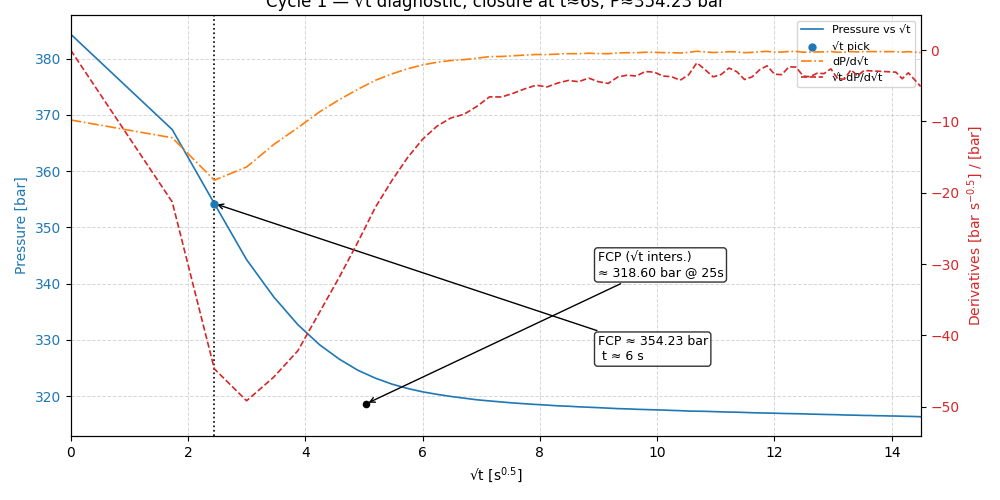

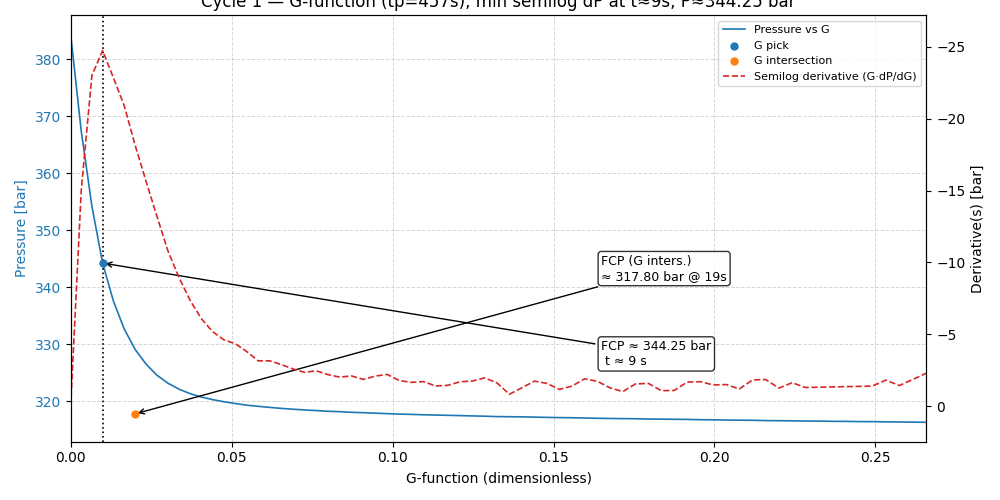

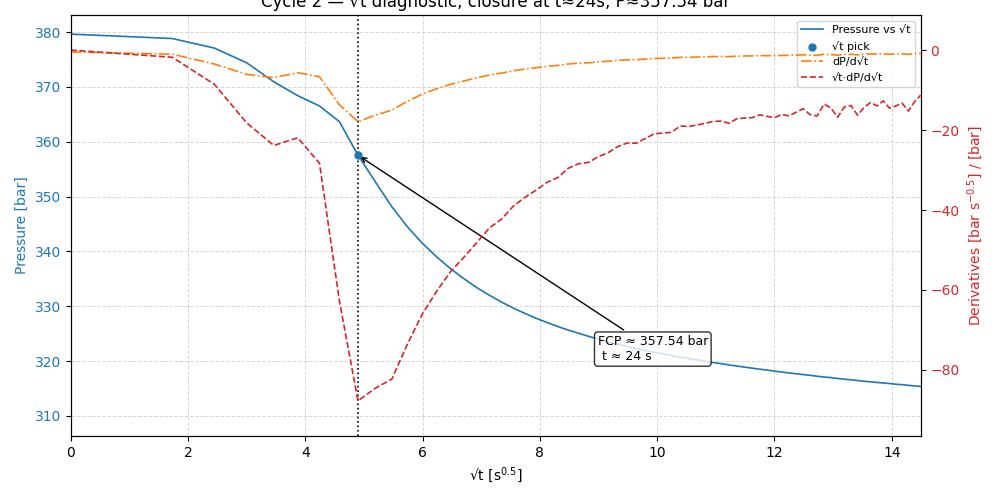

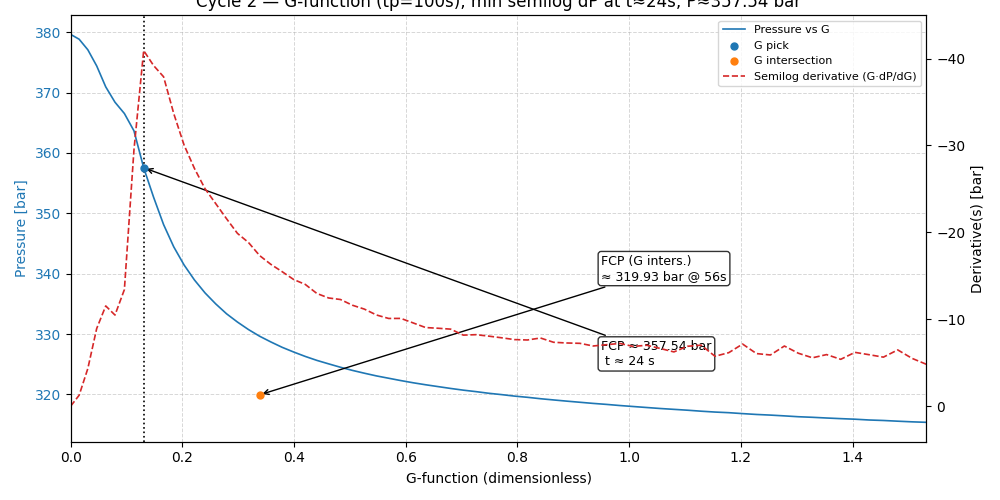

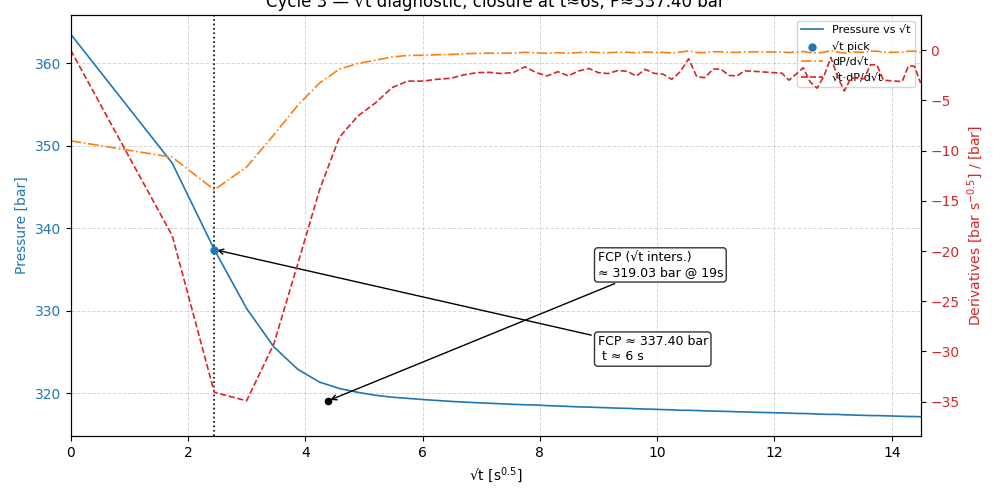

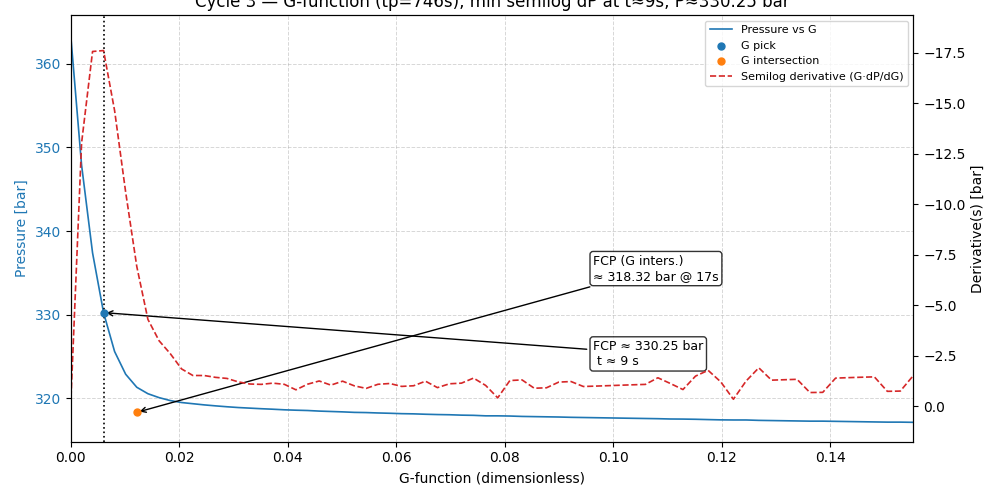

In [11]:
# ----------------------------
# PER-CYCLE diagnostics & plots (for every detected cycle)
# ----------------------------
MIN_T_S_FOR_PICK = 0   # e.g., set to 90 to ignore the first 90 s

if len(cycles) == 0:
    print("No cycles detected — nothing to analyze.")
else:
    print("\nPer-cycle closure analysis (√t & G-function within 0–180 s):")
    for i, cyc in enumerate(cycles, 1):
        # Convert cycle window to DOWNHOLE clock
        t_shut_D = cyc['t_shut_in_surface'] - pd.to_timedelta(float(lag_s), unit='s')
        t_end_D  = cyc['t_end_surface']      - pd.to_timedelta(float(lag_s), unit='s')

        # Build + cap falloff series
        ts_dh, p_dh = closure_analysis.build_shut_in_series(time_D, p_downhole_corr, t_shut_D)
        t_end_rel   = (pd.to_datetime(t_end_D) - pd.to_datetime(t_shut_D)).total_seconds()
        t_hard_cap  = min(float(t_end_rel), float(CAP_S))
        keep        = (ts_dh <= t_hard_cap)
        ts_dh, p_dh = ts_dh[keep], p_dh[keep]

        # Require some usable falloff
        if len(ts_dh) < 3 or (ts_dh[-1] if len(ts_dh) else 0) < 120:
            print(f"  Cycle {i}: skipped (too short falloff: {ts_dh[-1] if len(ts_dh) else 0:.0f}s).")
            continue

        # --- √t diagnostic (QC) ---
        x_sqrt, p_srt, dpdx = closure_analysis.derivative_vs_sqrt_time(
            ts_dh, p_dh, max_t_s=CAP_S
        )
        i_srt = closure_analysis.suggest_closure_from_srt(
            x_sqrt, p_srt, dpdx, min_t_s=MIN_T_S_FOR_PICK, max_t_s=CAP_S
        )

        figSRT, (ax_left_srt, ax_right_srt) = plotting.plot_srt(
            x_sqrt, p_srt, dpdx, i_cl=i_srt, cap_s=CAP_S
        )

        # Title + annotation for √t pick
        if i_srt is not None and 0 <= i_srt < len(x_sqrt) and i_srt < len(p_srt):
            t_cl_srt = float(x_sqrt[i_srt] ** 2)
            p_cl_srt = float(p_srt[i_srt])
            ax_left_srt.set_title(
                f"Cycle {i} — √t diagnostic, closure at t≈{t_cl_srt:.0f}s, P≈{p_cl_srt:.2f} bar"
            )
            ax_left_srt.scatter([x_sqrt[i_srt]], [p_cl_srt], s=25, zorder=5, label="√t pick")
            ax_left_srt.annotate(
                f"FCP ≈ {p_cl_srt:.2f} bar\n t ≈ {t_cl_srt:.0f} s",
                xy=(x_sqrt[i_srt], p_cl_srt),
                xytext=(0.62, 0.18), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->"),
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                fontsize=9
            )
        else:
            ax_left_srt.set_title(
                f"Cycle {i} — √t diagnostic, no closure in [{int(MIN_T_S_FOR_PICK)}, {int(CAP_S)}] s"
            )

        # ===========================
        # √t INTERSECTION METHOD + overlay
        # ===========================
        try:
            res_srt = closure_analysis.fcp_by_sqrt_intersection(
                ts_dh, p_dh, max_t_s=CAP_S, min_left=8, min_right=8
            )
        except Exception:
            res_srt = {"ok": False}

        if res_srt.get("ok"):
            # numeric result
            try:
                cp_bar = float(res_srt.get("closure_pressure_bar"))
                ct_s   = float(res_srt.get("closure_time_s"))
            except Exception:
                cp_bar, ct_s = (np.nan, np.nan)

            # fits
            left_fit  = res_srt.get("left_fit",  (None, None))
            right_fit = res_srt.get("right_fit", (None, None))
            try:
                mL, bL = (float(left_fit[0]), float(left_fit[1]))
            except Exception:
                mL, bL = (np.nan, np.nan)
            try:
                mR, bR = (float(right_fit[0]), float(right_fit[1]))
            except Exception:
                mR, bR = (np.nan, np.nan)

            # split domain at closure (√t)
            if np.isfinite(ct_s) and ct_s >= 0:
                x_cl = np.sqrt(ct_s)
                xL = x_sqrt[x_sqrt <= x_cl]
                xR = x_sqrt[x_sqrt >= x_cl]
            else:
                x_cl = np.nan
                xL, xR = x_sqrt, x_sqrt

            # overlays
            if np.isfinite(mL) and np.isfinite(bL) and len(xL) > 1:
                ax_left_srt.plot(xL, mL * xL + bL, ls="--", lw=1.2, c="k", label="√t left fit")
            if np.isfinite(mR) and np.isfinite(bR) and len(xR) > 1:
                ax_left_srt.plot(xR, mR * xR + bR, ls="--", lw=1.2, c="k", label="√t right fit")

            if np.isfinite(x_cl) and np.isfinite(cp_bar):
                ax_left_srt.scatter([x_cl], [cp_bar], s=20, c="k", zorder=5)
                ax_left_srt.annotate(
                    f"FCP (√t inters.)\n≈ {cp_bar:.2f} bar @ {ct_s:.0f}s",
                    xy=(x_cl, cp_bar),
                    xytext=(0.62, 0.38), textcoords="axes fraction",
                    arrowprops=dict(arrowstyle="->"),
                    bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                    fontsize=9
                )

            # legend combine (left+right)
            h1, l1 = ax_left_srt.get_legend_handles_labels()
            h2, l2 = ax_right_srt.get_legend_handles_labels()
            ax_left_srt.legend(h1 + h2, l1 + l2, loc="best", fontsize=8)

        # --- G-function diagnostic (Barree/Nolte) ---
        try:
            tp_s = (cyc['t_shut_in_surface'] - cyc['t_pump_start_surface']).total_seconds()
        except Exception:
            tp_s = 0.0
        if not np.isfinite(tp_s) or tp_s <= 0:
            tp_s = max(1.0, ts_dh[0] if len(ts_dh) else 1.0)  # safe fallback

        G = closure_analysis.g_function_high_efficiency(ts_dh, tp_s)
        semilog_dP = closure_analysis.semilog_derivative(G, p_dh)
        i_g = None
        if len(G) >= 3 and np.isfinite(semilog_dP).any():
            mwin = (
                (ts_dh >= float(MIN_T_S_FOR_PICK)) &
                (ts_dh <= float(CAP_S)) &
                np.isfinite(semilog_dP)
            )
            if mwin.any():
                idx = np.where(mwin)[0]
                i_g = idx[np.nanargmin(semilog_dP[idx])]

        figG, (axG_left, axG_right) = plotting.plot_gfunction(
            ts_seconds=ts_dh,
            p=p_dh,
            tp_seconds=tp_s,
            p_times=ts_dh,
            i_cl=i_g,
            cap_s=CAP_S,
            plot_normal=False
        )

        # Title + annotation for G pick
        if i_g is not None and 0 <= i_g < len(ts_dh) and i_g < len(p_dh):
            axG_left.set_title(
                f"Cycle {i} — G-function (tp={tp_s:.0f}s), min semilog dP at t≈{ts_dh[i_g]:.0f}s, "
                f"P≈{p_dh[i_g]:.2f} bar"
            )
            axG_left.scatter([G[i_g]], [p_dh[i_g]], s=25, zorder=5, label="G pick")
            axG_left.annotate(
                f"FCP ≈ {p_dh[i_g]:.2f} bar\n t ≈ {ts_dh[i_g]:.0f} s",
                xy=(G[i_g], p_dh[i_g]),
                xytext=(0.62, 0.18), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->"),
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                fontsize=9
            )
        else:
            axG_left.set_title(
                f"Cycle {i} — G-function (tp={tp_s:.0f}s), no min in [{int(MIN_T_S_FOR_PICK)}, {int(CAP_S)}] s"
            )

        # =======================
        # G INTERSECTION METHOD + overlay
        # =======================
        try:
            res_g = closure_analysis.fcp_by_g_intersection(
                ts_dh, p_dh, tp_seconds=tp_s, max_t_s=CAP_S, min_left=8, min_right=8
            )
        except Exception:
            res_g = {"ok": False}

        if res_g.get("ok"):
            try:
                cp_bar_g = float(res_g.get("closure_pressure_bar"))
                ct_s_g   = float(res_g.get("closure_time_s"))
            except Exception:
                cp_bar_g, ct_s_g = (np.nan, np.nan)

            left_fit_g  = res_g.get("left_fit",  (None, None))
            right_fit_g = res_g.get("right_fit", (None, None))
            try:    mL_g, bL_g = (float(left_fit_g[0]),  float(left_fit_g[1]))
            except: mL_g, bL_g = (np.nan, np.nan)
            try:    mR_g, bR_g = (float(right_fit_g[0]), float(right_fit_g[1]))
            except: mR_g, bR_g = (np.nan, np.nan)

            # closure G*
            G_cl = res_g.get("closure_G", None)
            if G_cl is None and np.isfinite(ct_s_g):
                k = int(np.argmin(np.abs(ts_dh - ct_s_g)))
                G_cl = G[k] if 0 <= k < len(G) else np.nan
            try:
                G_cl = float(G_cl)
            except Exception:
                G_cl = np.nan

            # overlays
            if np.isfinite(G_cl):
                GL = G[G <= G_cl]
                GR = G[G >= G_cl]
            else:
                GL = GR = G

            if np.isfinite(mL_g) and np.isfinite(bL_g) and len(GL) > 1:
                axG_left.plot(GL, mL_g * GL + bL_g, ls="--", lw=1.2, c="k", label="G left fit")
            if np.isfinite(mR_g) and np.isfinite(bR_g) and len(GR) > 1:
                axG_left.plot(GR, mR_g * GR + bR_g, ls="--", lw=1.2, c="k", label="G right fit")

            if np.isfinite(G_cl) and np.isfinite(cp_bar_g):
                axG_left.scatter([G_cl], [cp_bar_g], s=25, zorder=5, label="G intersection")
                axG_left.annotate(
                    f"FCP (G inters.)\n≈ {cp_bar_g:.2f} bar @ {ct_s_g:.0f}s",
                    xy=(G_cl, cp_bar_g),
                    xytext=(0.62, 0.38), textcoords="axes fraction",
                    arrowprops=dict(arrowstyle="->"),
                    bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                    fontsize=9
                )

        # Refresh combined legend (left + right) for G
        h1, l1 = axG_left.get_legend_handles_labels()
        h2, l2 = axG_right.get_legend_handles_labels()
        axG_left.legend(h1 + h2, l1 + l2, loc="best", fontsize=8)

        # -----------------
        # Collect & print the results (grouped per cycle) — NO BOURDET
        # -----------------
        def _fmt(val, nd=2, fallback="—"):
            try:
                v = float(val)
                if np.isfinite(v):
                    return f"{v:.{nd}f}"
            except Exception:
                pass
            return fallback

        lines = []

        # 1) √t pick
        if i_srt is not None and 0 <= i_srt < len(p_srt):
            t_srt_pick = (x_sqrt[i_srt] ** 2) if i_srt < len(x_sqrt) else np.nan
            lines.append(
                f"  Cycle {i}: FCP (√t)      ≈ {_fmt(p_srt[i_srt])} bar at t ≈ {_fmt(t_srt_pick, 0)} s "
                f"(ended by {cyc['ended_by']}, window {t_hard_cap:.0f}s)"
            )
        else:
            lines.append(
                f"  Cycle {i}: FCP (√t)      — not found "
                f"(ended by {cyc['ended_by']}, window {t_hard_cap:.0f}s)"
            )

        # 2) G-function pick
        if i_g is not None and 0 <= i_g < len(p_dh):
            lines.append(
                f"            FCP (G-func)  ≈ {_fmt(p_dh[i_g])} bar at t ≈ {_fmt(ts_dh[i_g], 0)} s "
                f"(tp={_fmt(tp_s, 0)}s)"
            )
        else:
            lines.append(f"            FCP (G-func)  — not found (tp={_fmt(tp_s, 0)}s)")

        # 3) √t intersection
        if res_srt.get("ok"):
            cp_bar = res_srt.get("closure_pressure_bar")
            ct_s   = res_srt.get("closure_time_s")
            lines.append(
                f"            FCP (√t inters.) ≈ {_fmt(cp_bar)} bar at t ≈ {_fmt(ct_s, 0)} s"
            )
        else:
            lines.append("            FCP (√t inters.) — not available")

        # 4) G intersection
        if res_g.get("ok"):
            cp_bar_g = res_g.get("closure_pressure_bar")
            ct_s_g   = res_g.get("closure_time_s")
            lines.append(
                f"            FCP (G inters.)  ≈ {_fmt(cp_bar_g)} bar at t ≈ {_fmt(ct_s_g, 0)} s "
                f"(tp={_fmt(tp_s, 0)}s)"
            )
        else:
            lines.append(f"            FCP (G inters.)  — not available (tp={_fmt(tp_s, 0)}s)")

        # Emit the lines for THIS cycle together
        print("\n".join(lines))

In [12]:
# --- Manual shut-in support (surface clock) ---
# Provide your list (strings or pd.Timestamp):
# MANUAL_SHUTINS_SURFACE = ["2023-12-10 15:25:16", "2023-12-10 16:46:40", "2023-12-10 17:15:19"]

MANUAL_TOL_S = 90  # seconds tolerance to match a cycle
_manuals = pd.DatetimeIndex(pd.to_datetime(MANUAL_SHUTINS_SURFACE)) if ('MANUAL_SHUTINS_SURFACE' in globals() and MANUAL_SHUTINS_SURFACE) else pd.DatetimeIndex([])

# snap manuals to nearest surface sample (prevents sub-sample drift)
def _snap_to_surface_grid(manuals, surface_times):
    if len(manuals) == 0:
        return pd.DatetimeIndex([])
    tvals = pd.to_datetime(surface_times).values.astype("datetime64[ns]")
    snapped = []
    for m in manuals:
        idx = int(np.argmin(np.abs(tvals - np.datetime64(pd.Timestamp(m)))))
        snapped.append(pd.Timestamp(tvals[idx]))
    return pd.DatetimeIndex(snapped).unique().sort_values()

_manuals_snapped = _snap_to_surface_grid(_manuals, time_S)
_MAN_TOL = pd.Timedelta(seconds=int(MANUAL_TOL_S))

def pick_manual_for_cycle(cyc, manuals_snapped, tol):
    """
    Choose the manual shut-in for this cycle, if any:
      1) Prefer manual closest to the auto shut-in within ±tol.
      2) Else, any manual inside [pump_start, end] window (pick the earliest).
      3) Else, None.
    """
    if manuals_snapped is None or len(manuals_snapped) == 0:
        return None

    t_start = pd.Timestamp(cyc['t_pump_start_surface'])
    t_auto  = pd.Timestamp(cyc['t_shut_in_surface'])
    t_end   = pd.Timestamp(cyc['t_end_surface'])

    # 1) nearest to auto within tol (use Series to get .abs())
    deltas = manuals_snapped - t_auto                       # TimedeltaIndex
    abs_deltas = pd.Series(deltas, index=manuals_snapped).abs()  # Series[Timedelta]
    if len(abs_deltas) > 0:
        k = int(abs_deltas.values.argmin())
        if abs_deltas.iloc[k] <= tol:
            return abs_deltas.index[k]

    # 2) any manual inside this cycle window
    in_win = manuals_snapped[(manuals_snapped >= t_start) & (manuals_snapped <= t_end)]
    if len(in_win) > 0:
        return in_win[0]

    return None


Per-cycle closure analysis (√t & G-function within 0–180 s):
  Cycle 1: FCP (√t)          ≈ 354.23 bar at t ≈ 6 s (ended by flowback, window 210s; shut-in=manual)
            FCP (G-func)      ≈ 344.25 bar at t ≈ 9 s (tp=457s)
            FCP (√t inters.)  ≈ 318.60 bar at t ≈ 25 s
            FCP (G inters.)   ≈ 317.80 bar at t ≈ 19 s (tp=457s)


/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_6629/407630646.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=pad, rect=[0, 0, 1, top])


  Cycle 2: FCP (√t)          ≈ 357.54 bar at t ≈ 24 s (ended by flowback, window 210s; shut-in=manual)
            FCP (G-func)      ≈ 357.54 bar at t ≈ 24 s (tp=100s)
            FCP (√t inters.)  ≈ 309.84 bar at t ≈ 406 s
            FCP (G inters.)   ≈ 319.93 bar at t ≈ 56 s (tp=100s)


/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_6629/407630646.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=pad, rect=[0, 0, 1, top])
/Users/william/Desktop/Thesis-AES/old_code/plotting.py:372: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax_left = plt.subplots(figsize=figsize)


  Cycle 3: FCP (√t)          ≈ 337.40 bar at t ≈ 6 s (ended by flowback, window 210s; shut-in=manual)
            FCP (G-func)      ≈ 330.25 bar at t ≈ 9 s (tp=746s)
            FCP (√t inters.)  ≈ 319.03 bar at t ≈ 19 s
            FCP (G inters.)   ≈ 318.32 bar at t ≈ 17 s (tp=746s)


/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_6629/407630646.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=pad, rect=[0, 0, 1, top])


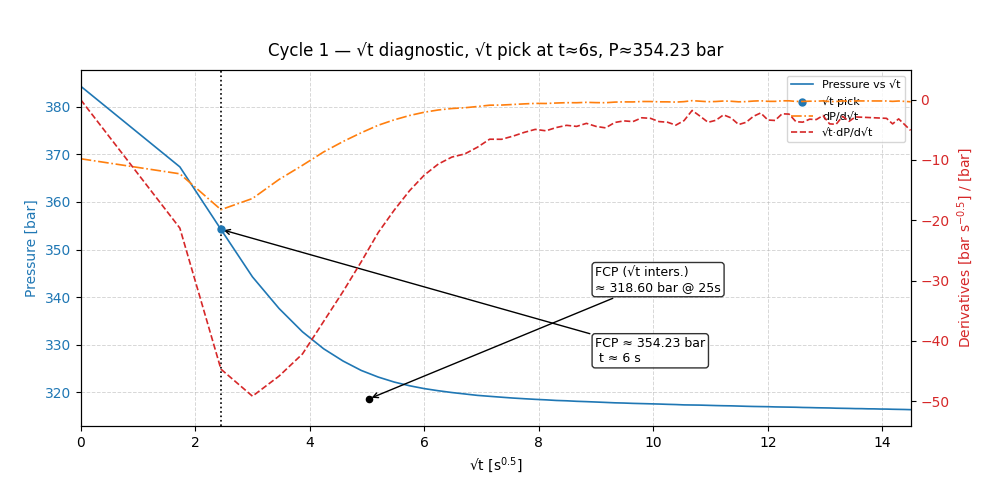

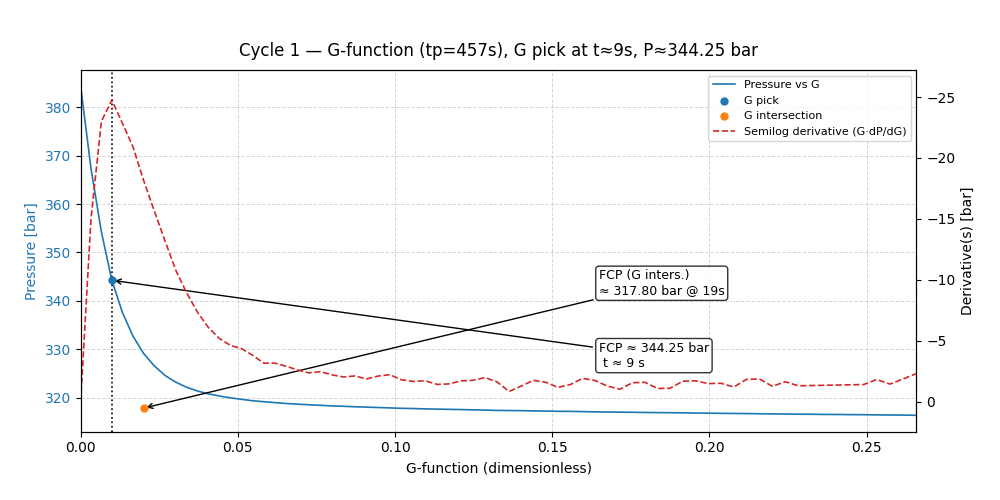

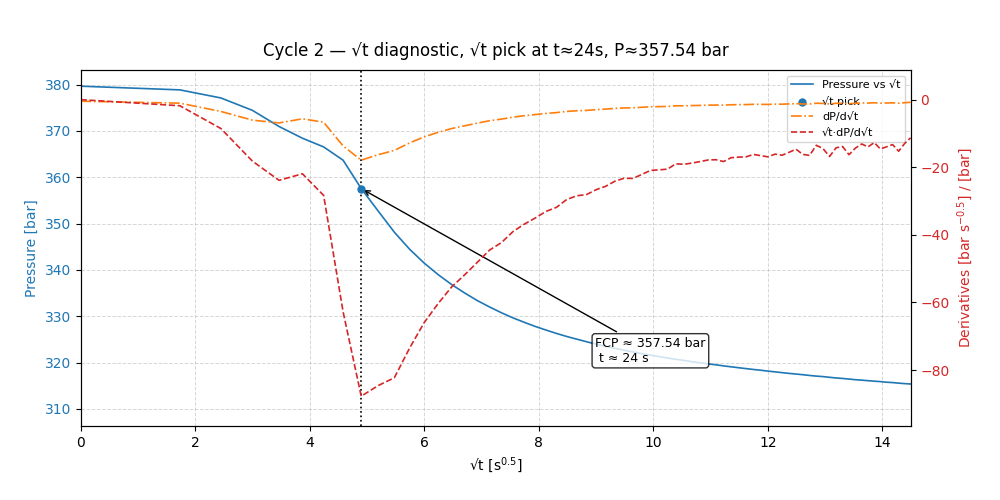

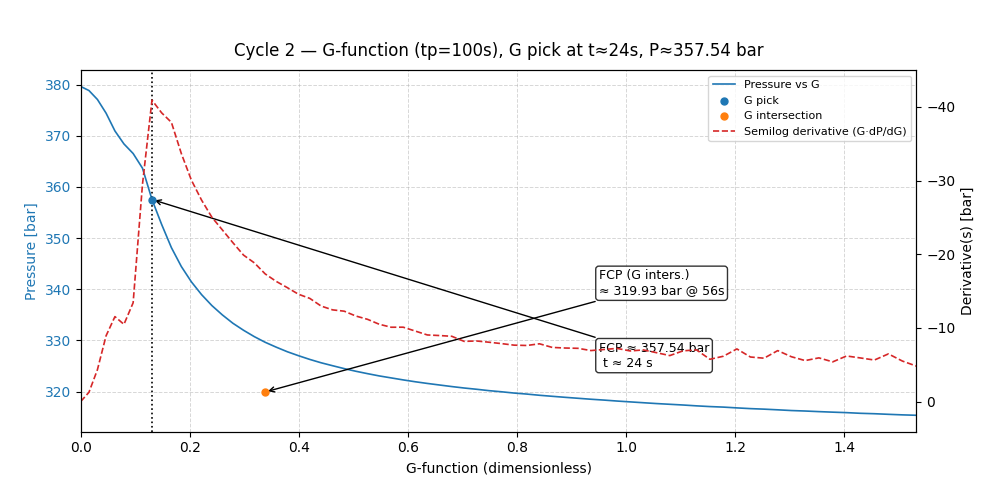

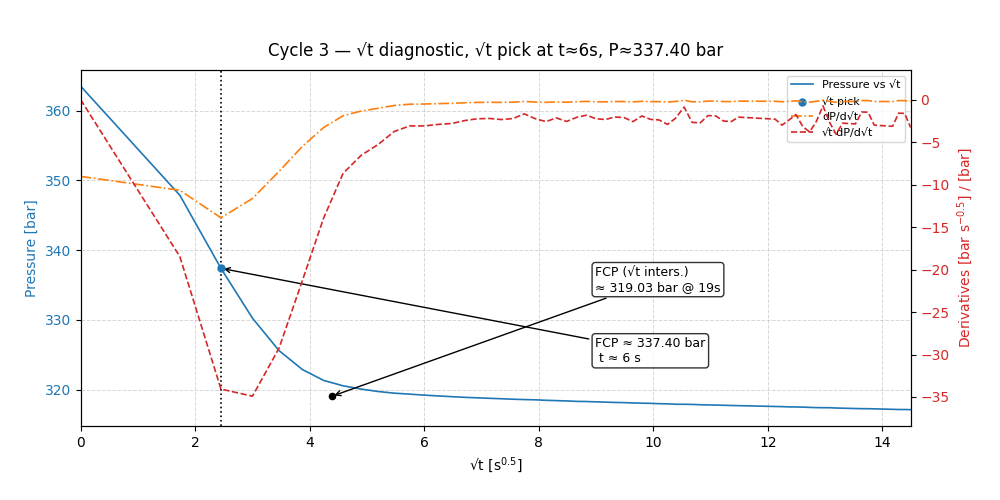

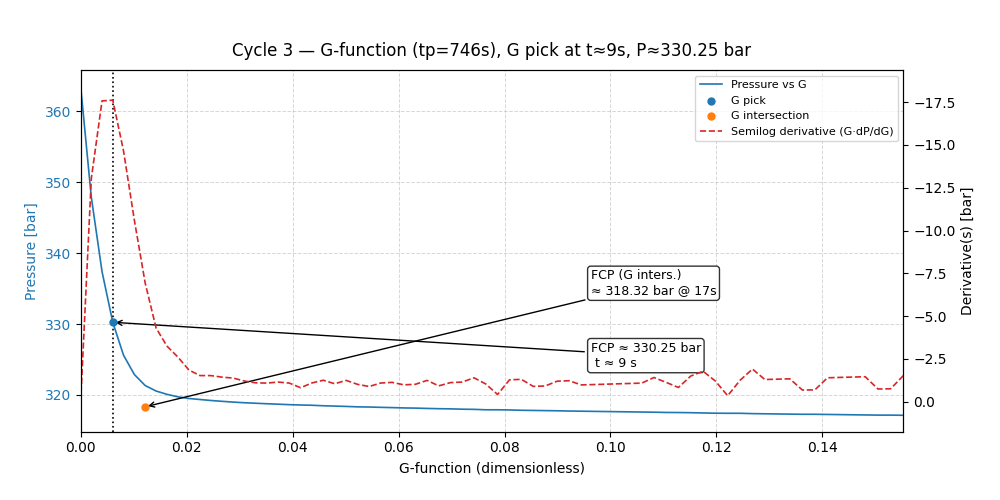

In [13]:
# -*- coding: utf-8 -*-
# Per-cycle diagnostics & plots (your current version) with extra spacing so titles aren't clipped
# in %matplotlib widget view. Adds: TITLE_PAD, relax_layout(fig), and HTML spacers between figures.

import numpy as np
import pandas as pd
from IPython.display import display, HTML

# ----------------------------
# Layout controls for better spacing in widget view
# ----------------------------
TITLE_PAD = 10  # extra pixels between axes and its title

def relax_layout(fig, top=0.86, pad=1.8, hspace=0.45, wspace=0.25):
    """Expand margins & spacing so titles don't get cut off in widget view."""
    try:
        fig.set_constrained_layout(True)
        fig.set_constrained_layout_pads(h_pad=0.2, w_pad=0.2,
                                        hspace=hspace, wspace=wspace)
    except Exception:
        pass
    try:
        fig.tight_layout(pad=pad, rect=[0, 0, 1, top])
        fig.subplots_adjust(top=top, hspace=hspace, wspace=wspace)
    except Exception:
        pass

# ----------------------------
# PER-CYCLE diagnostics & plots (concise refactor)
# ----------------------------
MIN_T_S_FOR_PICK = 0  # e.g., set to 90 to ignore the first 90 s

# ---------- small utilities ----------
_fmt = lambda v, nd=2, fb="—": (f"{float(v):.{nd}f}" if (v is not None and np.isfinite(float(v))) else fb)

def choose_shutin(cyc, manuals, tol):
    t_manual = pick_manual_for_cycle(cyc, manuals, tol)
    return pd.Timestamp(t_manual) if t_manual is not None else pd.Timestamp(cyc["t_shut_in_surface"])

def to_downhole(t_surface, lag_s):
    lag = pd.to_timedelta(float(lag_s), unit="s")
    return pd.Timestamp(t_surface) - lag

def build_falloff(time_D, p_D, t_shut_D, t_end_D, cap_s):
    ts_dh, p_dh = closure_analysis.build_shut_in_series(time_D, p_D, t_shut_D)
    t_end_rel = (pd.to_datetime(t_end_D) - pd.to_datetime(t_shut_D)).total_seconds()
    t_cap = min(float(t_end_rel), float(cap_s))
    keep = (ts_dh <= t_cap)
    return ts_dh[keep], p_dh[keep], t_cap

def annotate_pick(ax, x, y, title_prefix, t_s, p_bar, pick_label, xytext=(0.62, 0.18)):
    ax.set_title(f"{title_prefix}, {pick_label} at t≈{t_s:.0f}s, P≈{p_bar:.2f} bar", pad=TITLE_PAD)
    ax.scatter([x], [y], s=25, zorder=5, label=pick_label)
    ax.annotate(
        f"FCP ≈ {p_bar:.2f} bar\n t ≈ {t_s:.0f} s",
        xy=(x, y), xytext=xytext, textcoords="axes fraction",
        arrowprops=dict(arrowstyle="->"),
        bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8), fontsize=9
    )

def overlay_fit(ax, x, fit, label):
    m, b = fit
    if m is None or b is None:
        return
    m, b = float(m), float(b)
    if np.isfinite(m) and np.isfinite(b) and len(x) > 1:
        ax.plot(x, m * x + b, ls="--", lw=1.2, c="k", label=label)

def combine_legends(ax_left, ax_right):
    h1, l1 = ax_left.get_legend_handles_labels()
    h2, l2 = ax_right.get_legend_handles_labels()
    ax_left.legend(h1 + h2, l1 + l2, loc="best", fontsize=8)

# ---------- diagnostics: √t ----------
def run_sqrt_diag(ts_dh, p_dh, cap_s, min_t_s, cycle_idx, ended_by, shut_label):
    out = {"title": f"Cycle {cycle_idx} — √t diagnostic"}
    x_sqrt, p_srt, dpdx = closure_analysis.derivative_vs_sqrt_time(ts_dh, p_dh, max_t_s=cap_s)
    i_pick = closure_analysis.suggest_closure_from_srt(x_sqrt, p_srt, dpdx,
                                                       min_t_s=min_t_s, max_t_s=cap_s)
    fig, (axL, axR) = plotting.plot_srt(x_sqrt, p_srt, dpdx, i_cl=i_pick, cap_s=cap_s)
    # expand spacing
    relax_layout(fig)

    # title + annotation
    if i_pick is not None and 0 <= i_pick < len(x_sqrt) and i_pick < len(p_srt):
        t_cl = float(x_sqrt[i_pick] ** 2); p_cl = float(p_srt[i_pick])
        annotate_pick(axL, x_sqrt[i_pick], p_cl, out["title"], t_cl, p_cl, "√t pick")
        out.update({"t_cl": t_cl, "p_cl": p_cl})
    else:
        axL.set_title(f"{out['title']}, no closure in [{int(min_t_s)}, {int(cap_s)}] s", pad=TITLE_PAD)
        out.update({"t_cl": None, "p_cl": None})

    # intersection method + overlays
    try:
        res = closure_analysis.fcp_by_sqrt_intersection(ts_dh, p_dh, max_t_s=cap_s, min_left=8, min_right=8)
    except Exception:
        res = {"ok": False}
    out["res_inter"] = res

    if res.get("ok"):
        cp, ct = map(lambda k: float(res.get(k, np.nan)), ("closure_pressure_bar", "closure_time_s"))
        x_cl = np.sqrt(ct) if np.isfinite(ct) and ct >= 0 else np.nan
        # split domains and overlay fits
        if np.isfinite(x_cl):
            overlay_fit(axL, x_sqrt[x_sqrt <= x_cl], res.get("left_fit", (None, None)),  "√t left fit")
            overlay_fit(axL, x_sqrt[x_sqrt >= x_cl], res.get("right_fit", (None, None)), "√t right fit")
            if np.isfinite(cp):
                axL.scatter([x_cl], [cp], s=20, c="k", zorder=5)
                axL.annotate(f"FCP (√t inters.)\n≈ {cp:.2f} bar @ {ct:.0f}s",
                             xy=(x_cl, cp), xytext=(0.62, 0.38), textcoords="axes fraction",
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8), fontsize=9)
        out.update({"cp_inter": cp, "ct_inter": ct})
    else:
        out.update({"cp_inter": None, "ct_inter": None})

    out.update({"fig": fig, "axL": axL, "axR": axR, "x_sqrt": x_sqrt, "p_srt": p_srt})
    return out

# ---------- diagnostics: G-function ----------
def run_g_diag(ts_dh, p_dh, tp_s, cap_s, min_t_s, cycle_idx):
    out = {"title": f"Cycle {cycle_idx} — G-function (tp={tp_s:.0f}s)"}
    G = closure_analysis.g_function_high_efficiency(ts_dh, tp_s)
    semilog_dP = closure_analysis.semilog_derivative(G, p_dh)

    # pick = min semilog derivative in window
    mwin = (ts_dh >= float(min_t_s)) & (ts_dh <= float(cap_s)) & np.isfinite(semilog_dP)
    i_pick = (np.where(mwin)[0][np.nanargmin(semilog_dP[mwin])] if mwin.any() else None)

    fig, (axL, axR) = plotting.plot_gfunction(
        ts_seconds=ts_dh, p=p_dh, tp_seconds=tp_s, p_times=ts_dh,
        i_cl=i_pick, cap_s=cap_s, plot_normal=False
    )
    # expand spacing
    relax_layout(fig)

    if i_pick is not None and 0 <= i_pick < len(ts_dh):
        annotate_pick(axL, G[i_pick], p_dh[i_pick], out["title"], float(ts_dh[i_pick]),
                      float(p_dh[i_pick]), "G pick")
        out.update({"t_cl": float(ts_dh[i_pick]), "p_cl": float(p_dh[i_pick])})
    else:
        axL.set_title(f"{out['title']}, no min in [{int(min_t_s)}, {int(cap_s)}] s", pad=TITLE_PAD)
        out.update({"t_cl": None, "p_cl": None})

    # intersection method
    try:
        res = closure_analysis.fcp_by_g_intersection(ts_dh, p_dh, tp_seconds=tp_s,
                                                     max_t_s=cap_s, min_left=8, min_right=8)
    except Exception:
        res = {"ok": False}
    out["res_inter"] = res

    if res.get("ok"):
        cp, ct = map(lambda k: float(res.get(k, np.nan)), ("closure_pressure_bar", "closure_time_s"))
        G_cl = res.get("closure_G", None)
        if G_cl is None and np.isfinite(ct):
            k = int(np.argmin(np.abs(ts_dh - ct)))
            G_cl = (G[k] if 0 <= k < len(G) else np.nan)
        G_cl = float(G_cl) if G_cl is not None else np.nan

        # overlay fits
        if np.isfinite(G_cl):
            overlay_fit(axL, G[G <= G_cl], res.get("left_fit", (None, None)),  "G left fit")
            overlay_fit(axL, G[G >= G_cl], res.get("right_fit", (None, None)), "G right fit")
            if np.isfinite(cp):
                axL.scatter([G_cl], [cp], s=25, zorder=5, label="G intersection")
                axL.annotate(f"FCP (G inters.)\n≈ {cp:.2f} bar @ {ct:.0f}s",
                             xy=(G_cl, cp), xytext=(0.62, 0.38), textcoords="axes fraction",
                             arrowprops=dict(arrowstyle="->"),
                             bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8), fontsize=9)
        out.update({"cp_inter": cp, "ct_inter": ct, "G_cl": G_cl})
    else:
        out.update({"cp_inter": None, "ct_inter": None, "G_cl": None})

    out.update({"fig": fig, "axL": axL, "axR": axR})
    return out

# ---------- MAIN ----------
if not cycles:
    print("No cycles detected — nothing to analyze.")
else:
    print("\nPer-cycle closure analysis (√t & G-function within 0–180 s):")
    for i, cyc in enumerate(cycles, 1):
        # pick & map times
        t_shut_S = choose_shutin(cyc, _manuals_snapped, _MAN_TOL)
        t_end_S  = pd.Timestamp(cyc["t_end_surface"])
        t_shut_D = to_downhole(t_shut_S, lag_s)
        t_end_D  = to_downhole(t_end_S,  lag_s)

        # falloff build + cap
        ts_dh, p_dh, t_cap = build_falloff(time_D, p_downhole_corr, t_shut_D, t_end_D, CAP_S)

        # minimal usable falloff
        if len(ts_dh) < 3 or (ts_dh[-1] if len(ts_dh) else 0) < 120:
            print(f"  Cycle {i}: skipped (too short falloff: {ts_dh[-1] if len(ts_dh) else 0:.0f}s).")
            # spacer between cycles even when skipped
            display(HTML("<div style='height:24px'></div>"))
            continue

        # √t diag
        srt = run_sqrt_diag(ts_dh, p_dh, CAP_S, MIN_T_S_FOR_PICK,
                            i, cyc.get("ended_by", "?"), "manual" if t_shut_S in _manuals_snapped else "auto")

        # G diag (need tp_s referred to the chosen shut-in)
        try:
            tp_s = (t_shut_S - cyc["t_pump_start_surface"]).total_seconds()
        except Exception:
            tp_s = 0.0
        if not np.isfinite(tp_s) or tp_s <= 0:
            tp_s = max(1.0, ts_dh[0] if len(ts_dh) else 1.0)

        gdiag = run_g_diag(ts_dh, p_dh, tp_s, CAP_S, MIN_T_S_FOR_PICK, i)
        combine_legends(srt["axL"], srt["axR"])
        combine_legends(gdiag["axL"], gdiag["axR"])

        # results printout
        lines = []
        # √t pick
        if srt["t_cl"] is not None:
            lines.append(
                f"  Cycle {i}: FCP (√t)          ≈ {_fmt(srt['p_cl'])} bar at t ≈ {_fmt(srt['t_cl'], 0)} s "
                f"(ended by {cyc.get('ended_by','?')}, window {t_cap:.0f}s; shut-in={'manual' if t_shut_S in _manuals_snapped else 'auto'})"
            )
        else:
            lines.append(
                f"  Cycle {i}: FCP (√t)          — not found "
                f"(ended by {cyc.get('ended_by','?')}, window {t_cap:.0f}s; shut-in={'manual' if t_shut_S in _manuals_snapped else 'auto'})"
            )
        # G pick
        if gdiag["t_cl"] is not None:
            lines.append(f"            FCP (G-func)      ≈ {_fmt(gdiag['p_cl'])} bar at t ≈ {_fmt(gdiag['t_cl'], 0)} s (tp={_fmt(tp_s, 0)}s)")
        else:
            lines.append(f"            FCP (G-func)      — not found (tp={_fmt(tp_s, 0)}s)")
        # √t intersection
        if srt["res_inter"].get("ok"):
            lines.append(f"            FCP (√t inters.)  ≈ {_fmt(srt['cp_inter'])} bar at t ≈ {_fmt(srt['ct_inter'], 0)} s")
        else:
            lines.append("            FCP (√t inters.)  — not available")
        # G intersection
        if gdiag["res_inter"].get("ok"):
            lines.append(f"            FCP (G inters.)   ≈ {_fmt(gdiag['cp_inter'])} bar at t ≈ {_fmt(gdiag['ct_inter'], 0)} s (tp={_fmt(tp_s, 0)}s)")
        else:
            lines.append(f"            FCP (G inters.)   — not available (tp={_fmt(tp_s, 0)}s)")

        print("\n".join(lines))

        # --- visual spacer between cycles so titles don't crowd in widget view ---
        display(HTML("<div style='height:24px'></div>"))


Per-cycle closure analysis (√t & G-function within 0–180 s):


/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_6629/1982933843.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=pad, rect=[0, 0, 1, top])


  Cycle 1: FCP (√t)          ≈ 354.23 bar at t ≈ 6 s (ended by flowback, window 210s; shut-in=auto)
            FCP (G-func)      ≈ 344.25 bar at t ≈ 9 s (tp=457s)
            FCP (√t inters.)  ≈ 318.60 bar at t ≈ 25 s
            FCP (G inters.)   ≈ 317.80 bar at t ≈ 19 s (tp=457s)
            FCP (Barree tangent)  — not available
            FCP (Haimson bilinear) ≈ 311.45 bar


/Users/william/Desktop/Thesis-AES/old_code/plotting.py:774: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=pad, rect=[0, 0, 1, top])


/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_6629/1982933843.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=pad, rect=[0, 0, 1, top])


  Cycle 2: FCP (√t)          ≈ 357.54 bar at t ≈ 24 s (ended by flowback, window 210s; shut-in=auto)
            FCP (G-func)      ≈ 357.54 bar at t ≈ 24 s (tp=100s)
            FCP (√t inters.)  ≈ 309.84 bar at t ≈ 406 s
            FCP (G inters.)   ≈ 319.93 bar at t ≈ 56 s (tp=100s)
            FCP (Barree tangent)  — not available
            FCP (Haimson bilinear) ≈ 358.59 bar


/Users/william/Desktop/Thesis-AES/old_code/plotting.py:774: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=pad, rect=[0, 0, 1, top])


/var/folders/2m/6jtrps0d7n9gs5v3067trbzw0000gn/T/ipykernel_6629/1982933843.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=pad, rect=[0, 0, 1, top])


  Cycle 3: FCP (√t)          ≈ 337.40 bar at t ≈ 6 s (ended by flowback, window 210s; shut-in=auto)
            FCP (G-func)      ≈ 330.25 bar at t ≈ 9 s (tp=746s)
            FCP (√t inters.)  ≈ 319.03 bar at t ≈ 19 s
            FCP (G inters.)   ≈ 318.32 bar at t ≈ 17 s (tp=746s)
            FCP (Barree tangent)  — not available
            FCP (Haimson bilinear) ≈ 314.78 bar


/Users/william/Desktop/Thesis-AES/old_code/plotting.py:774: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=pad, rect=[0, 0, 1, top])


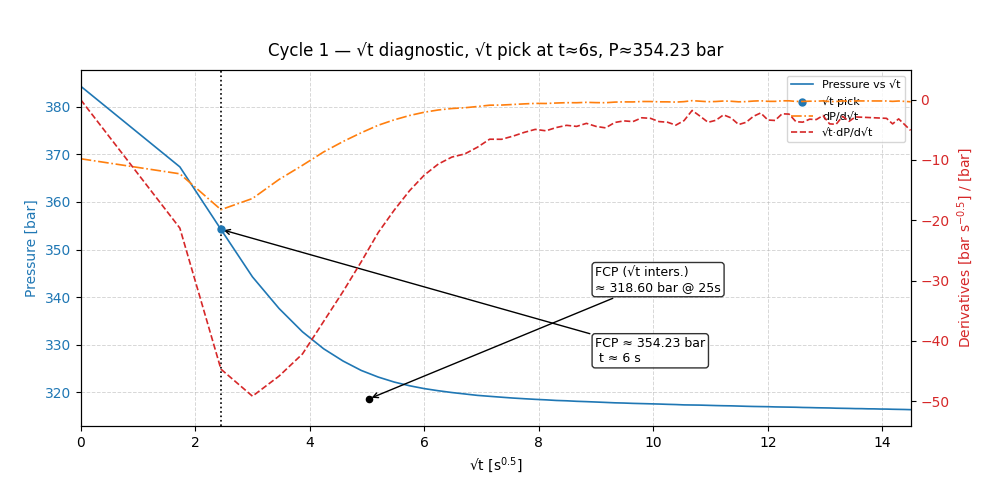

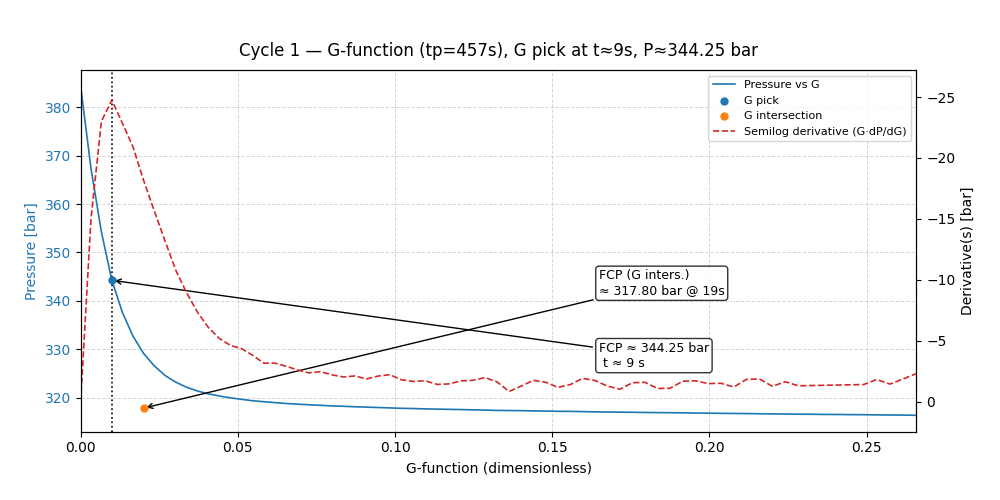

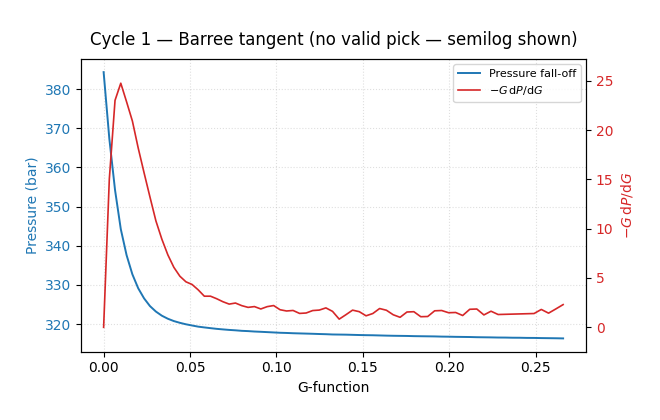

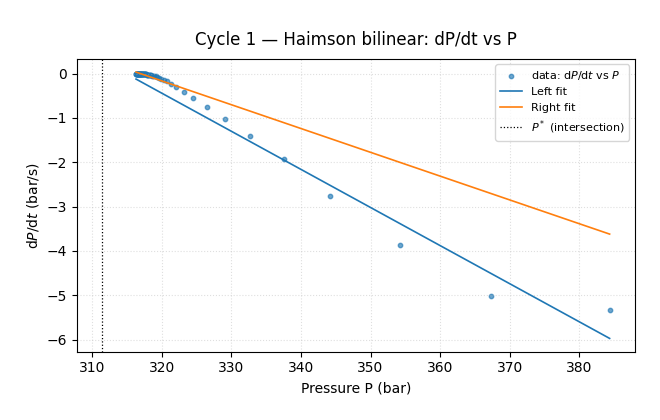

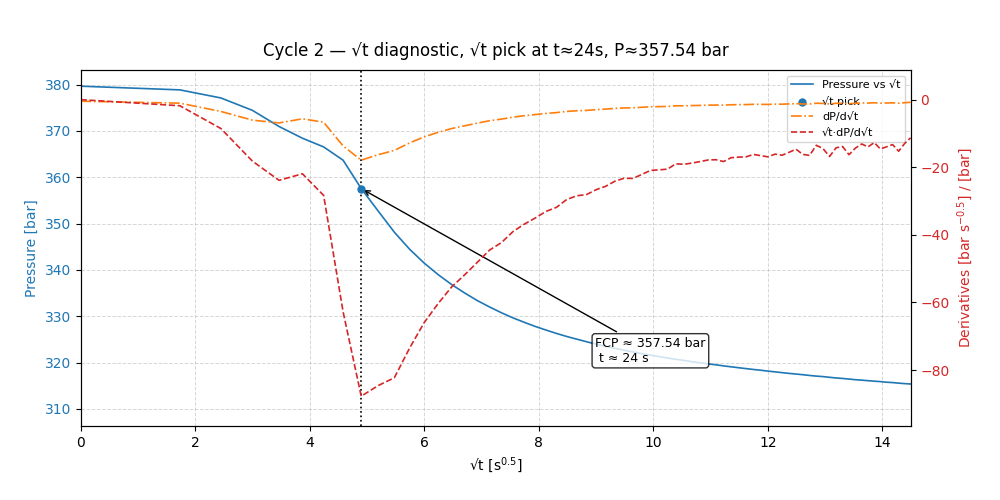

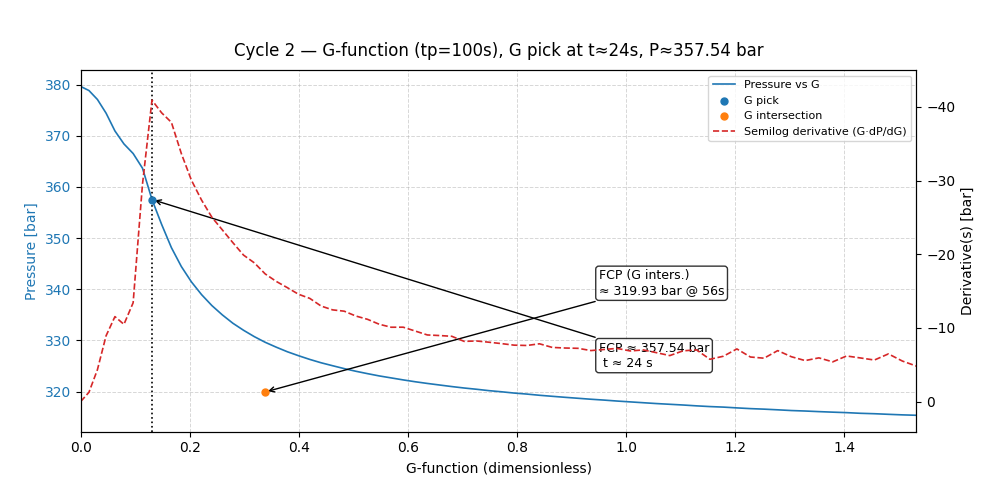

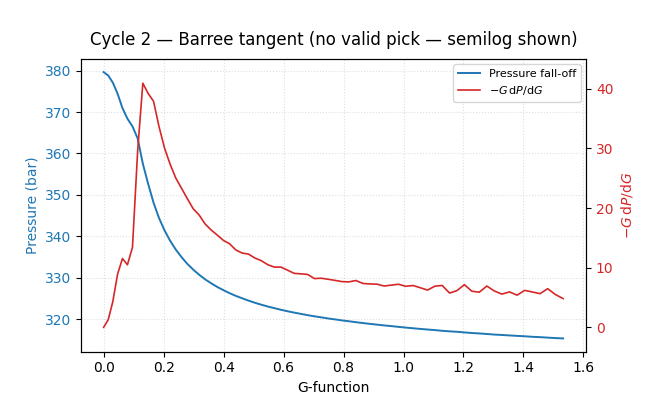

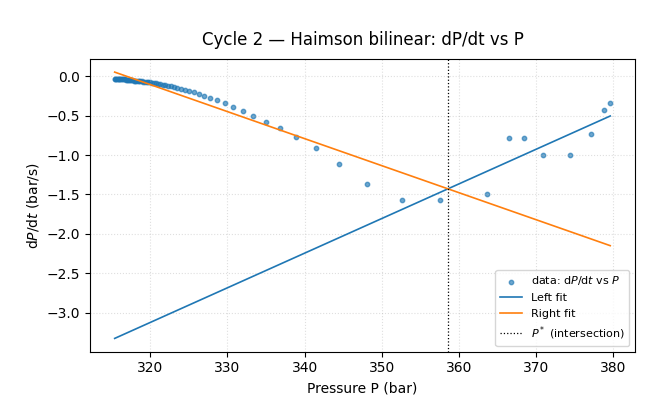

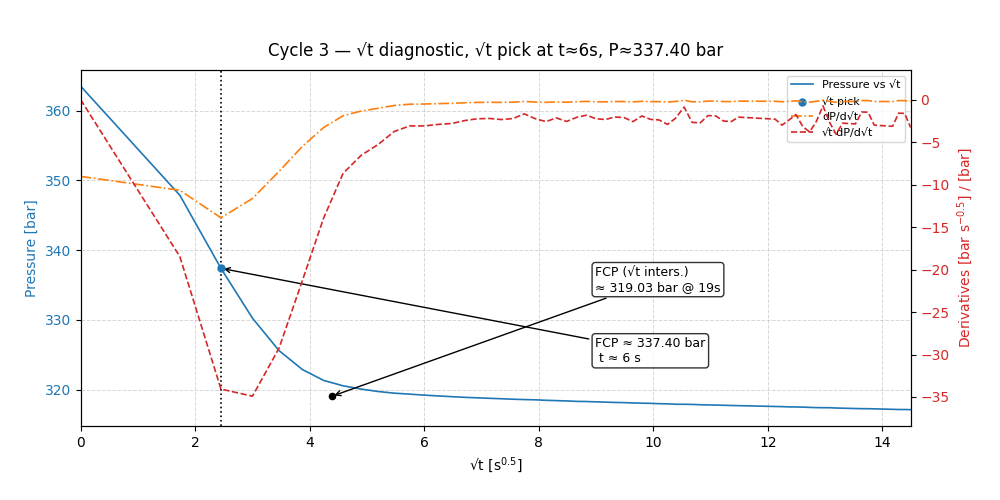

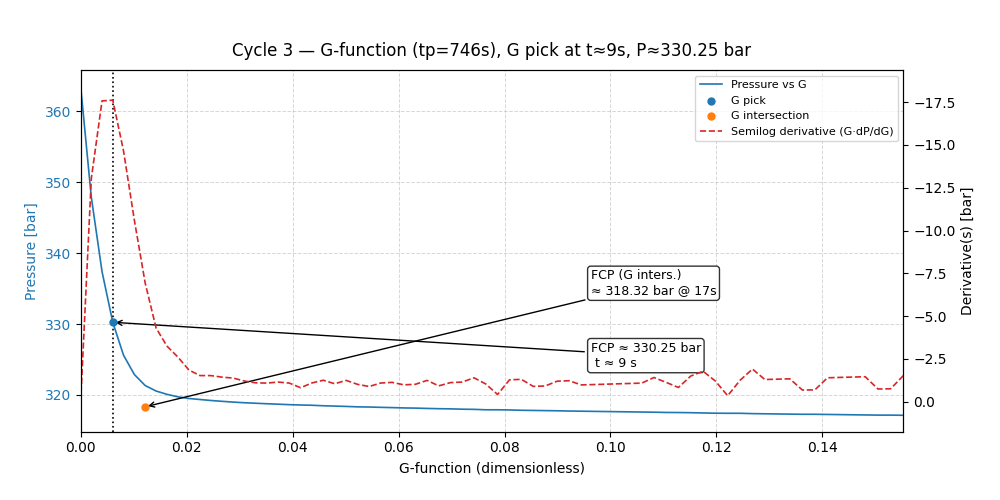

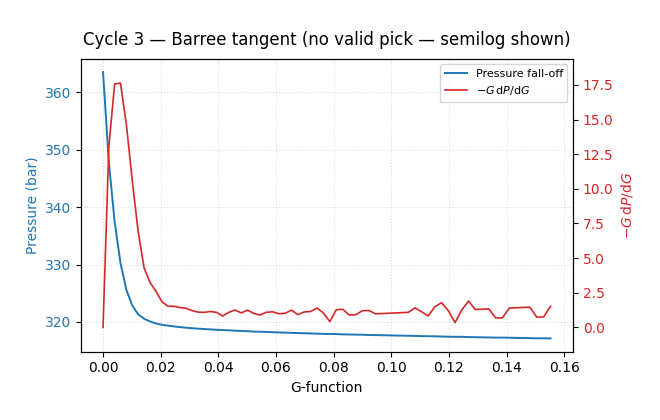

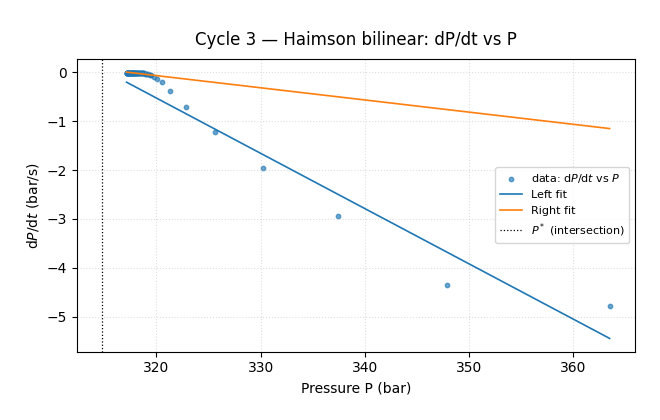

In [14]:
# -*- coding: utf-8 -*-
# Main notebook code: keeps your existing √t & G diagnostics, improves figure spacing,
# and ADDS Barree (tangent on semilog derivative) + Haimson (dP/dt vs P) FCP plots per cycle
# via plotting.py helpers.

from IPython.display import display, HTML

# ----------------------------
# Layout controls for better spacing in widget view (used by √t / G only;
# Barree/Haimson spacing is handled inside plotting.py)
# ----------------------------
TITLE_PAD = 10  # extra pixels between axes and its title

def relax_layout(fig, top=0.86, pad=1.8, hspace=0.45, wspace=0.25):
    try:
        fig.set_constrained_layout(True)
        fig.set_constrained_layout_pads(h_pad=0.2, w_pad=0.2,
                                        hspace=hspace, wspace=wspace)
    except Exception:
        pass
    try:
        fig.tight_layout(pad=pad, rect=[0, 0, 1, top])
        fig.subplots_adjust(top=top, hspace=hspace, wspace=wspace)
    except Exception:
        pass

# ----------------------------
# PER-CYCLE diagnostics & plots
# ----------------------------
MIN_T_S_FOR_PICK = 0  # e.g., set to 90 to ignore the first 90 s in automatic picks

# ---------- small utilities ----------
_fmt = lambda v, nd=2, fb="—": (f"{float(v):.{nd}f}" if (v is not None and np.isfinite(float(v))) else fb)

def choose_shutin(cyc, manuals, tol):
    t_manual = pick_manual_for_cycle(cyc, manuals, tol)
    return pd.Timestamp(t_manual) if t_manual is not None else pd.Timestamp(cyc["t_shut_in_surface"])

def to_downhole(t_surface, lag_s):
    lag = pd.to_timedelta(float(lag_s), unit="s")
    return pd.Timestamp(t_surface) - lag

def build_falloff(time_D, p_D, t_shut_D, t_end_D, cap_s):
    ts_dh, p_dh = closure_analysis.build_shut_in_series(time_D, p_D, t_shut_D)
    t_end_rel = (pd.to_datetime(t_end_D) - pd.to_datetime(t_shut_D)).total_seconds()
    t_cap = min(float(t_end_rel), float(cap_s))
    keep = (ts_dh <= t_cap)
    return ts_dh[keep], p_dh[keep], t_cap

def annotate_pick(ax, x, y, title_prefix, t_s, p_bar, pick_label, xytext=(0.62, 0.18)):
    ax.set_title(f"{title_prefix}, {pick_label} at t≈{t_s:.0f}s, P≈{p_bar:.2f} bar", pad=TITLE_PAD)
    ax.scatter([x], [y], s=25, zorder=5, label=pick_label)
    ax.annotate(
        f"FCP ≈ {p_bar:.2f} bar\n t ≈ {t_s:.0f} s",
        xy=(x, y), xytext=xytext, textcoords="axes fraction",
        arrowprops=dict(arrowstyle="->"),
        bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8), fontsize=9
    )

def overlay_fit(ax, x, fit, label):
    m, b = fit
    if m is None or b is None:
        return
    m, b = float(m), float(b)
    if np.isfinite(m) and np.isfinite(b) and len(x) > 1:
        ax.plot(x, m * x + b, ls="--", lw=1.2, c="k", label=label)

def combine_legends(ax_left, ax_right):
    h1, l1 = ax_left.get_legend_handles_labels()
    h2, l2 = ax_right.get_legend_handles_labels()
    ax_left.legend(h1 + h2, l1 + l2, loc="best", fontsize=8)

# ---------- diagnostics: √t ----------
def run_sqrt_diag(ts_dh, p_dh, cap_s, min_t_s, cycle_idx):
    out = {"title": f"Cycle {cycle_idx} — √t diagnostic"}
    x_sqrt, p_srt, dpdx = closure_analysis.derivative_vs_sqrt_time(ts_dh, p_dh, max_t_s=cap_s)
    i_pick = closure_analysis.suggest_closure_from_srt(
        x_sqrt, p_srt, dpdx, min_t_s=min_t_s, max_t_s=cap_s
    )
    fig, (axL, axR) = plotting.plot_srt(x_sqrt, p_srt, dpdx, i_cl=i_pick, cap_s=cap_s)
    relax_layout(fig)

    if i_pick is not None and 0 <= i_pick < len(x_sqrt) and i_pick < len(p_srt):
        t_cl = float(x_sqrt[i_pick] ** 2); p_cl = float(p_srt[i_pick])
        annotate_pick(axL, x_sqrt[i_pick], p_cl, out["title"], t_cl, p_cl, "√t pick")
        out.update({"t_cl": t_cl, "p_cl": p_cl})
    else:
        axL.set_title(f"{out['title']}, no closure in [{int(min_t_s)}, {int(cap_s)}] s", pad=TITLE_PAD)
        out.update({"t_cl": None, "p_cl": None})

    try:
        res = closure_analysis.fcp_by_sqrt_intersection(ts_dh, p_dh, max_t_s=cap_s, min_left=8, min_right=8)
    except Exception:
        res = {"ok": False}
    out["res_inter"] = res

    if res.get("ok"):
        cp, ct = map(lambda k: float(res.get(k, np.nan)), ("closure_pressure_bar", "closure_time_s"))
        x_cl = np.sqrt(ct) if np.isfinite(ct) and ct >= 0 else np.nan
        if np.isfinite(x_cl):
            overlay_fit(axL, x_sqrt[x_sqrt <= x_cl], res.get("left_fit", (None, None)),  "√t left fit")
            overlay_fit(axL, x_sqrt[x_sqrt >= x_cl], res.get("right_fit", (None, None)), "√t right fit")
            if np.isfinite(cp):
                axL.scatter([x_cl], [cp], s=20, c="k", zorder=5)
                axL.annotate(
                    f"FCP (√t inters.)\n≈ {cp:.2f} bar @ {ct:.0f}s",
                    xy=(x_cl, cp), xytext=(0.62, 0.38), textcoords="axes fraction",
                    arrowprops=dict(arrowstyle="->"),
                    bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8), fontsize=9
                )
        out.update({"cp_inter": cp, "ct_inter": ct})
    else:
        out.update({"cp_inter": None, "ct_inter": None})

    out.update({"fig": fig, "axL": axL, "axR": axR, "x_sqrt": x_sqrt, "p_srt": p_srt})
    return out

# ---------- diagnostics: G-function ----------
def run_g_diag(ts_dh, p_dh, tp_s, cap_s, min_t_s, cycle_idx):
    out = {"title": f"Cycle {cycle_idx} — G-function (tp={tp_s:.0f}s)"}
    G = closure_analysis.g_function_high_efficiency(ts_dh, tp_s)
    semilog_dP = closure_analysis.semilog_derivative(G, p_dh)

    i_pick = None
    if len(G) >= 3 and np.isfinite(semilog_dP).any():
        mwin = (ts_dh >= float(min_t_s)) & (ts_dh <= float(cap_s)) & np.isfinite(semilog_dP)
        if mwin.any():
            idx = np.where(mwin)[0]
            i_pick = idx[np.nanargmin(semilog_dP[idx])]

    fig, (axL, axR) = plotting.plot_gfunction(
        ts_seconds=ts_dh, p=p_dh, tp_seconds=tp_s, p_times=ts_dh,
        i_cl=i_pick, cap_s=cap_s, plot_normal=False
    )
    relax_layout(fig)

    if i_pick is not None and 0 <= i_pick < len(ts_dh):
        annotate_pick(axL, G[i_pick], p_dh[i_pick], out["title"], float(ts_dh[i_pick]),
                      float(p_dh[i_pick]), "G pick")
        out.update({"t_cl": float(ts_dh[i_pick]), "p_cl": float(p_dh[i_pick])})
    else:
        axL.set_title(f"{out['title']}, no min in [{int(min_t_s)}, {int(cap_s)}] s", pad=TITLE_PAD)
        out.update({"t_cl": None, "p_cl": None})

    try:
        res = closure_analysis.fcp_by_g_intersection(
            ts_dh, p_dh, tp_seconds=tp_s, max_t_s=cap_s, min_left=8, min_right=8
        )
    except Exception:
        res = {"ok": False}
    out["res_inter"] = res

    if res.get("ok"):
        cp, ct = map(lambda k: float(res.get(k, np.nan)), ("closure_pressure_bar", "closure_time_s"))
        G_cl = res.get("closure_G", None)
        if G_cl is None and np.isfinite(ct):
            k = int(np.argmin(np.abs(ts_dh - ct)))
            G_cl = (G[k] if 0 <= k < len(G) else np.nan)
        G_cl = float(G_cl) if G_cl is not None else np.nan

        if np.isfinite(G_cl):
            overlay_fit(axL, G[G <= G_cl], res.get("left_fit", (None, None)),  "G left fit")
            overlay_fit(axL, G[G >= G_cl], res.get("right_fit", (None, None)), "G right fit")
            if np.isfinite(cp):
                axL.scatter([G_cl], [cp], s=25, zorder=5, label="G intersection")
                axL.annotate(
                    f"FCP (G inters.)\n≈ {cp:.2f} bar @ {ct:.0f}s",
                    xy=(G_cl, cp), xytext=(0.62, 0.38), textcoords="axes fraction",
                    arrowprops=dict(arrowstyle="->"),
                    bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8), fontsize=9
                )
        out.update({"cp_inter": cp, "ct_inter": ct, "G_cl": G_cl})
    else:
        out.update({"cp_inter": None, "ct_inter": None, "G_cl": None})

    out.update({"fig": fig, "axL": axL, "axR": axR})
    return out

# ---------- MAIN ----------
if not cycles:
    print("No cycles detected — nothing to analyze.")
else:
    print("\nPer-cycle closure analysis (√t & G-function within 0–180 s):")
    for i, cyc in enumerate(cycles, 1):
        # pick & map times
        t_shut_S = choose_shutin(cyc, _manuals_snapped, _MAN_TOL)
        t_end_S  = pd.Timestamp(cyc["t_end_surface"])
        t_shut_D = to_downhole(t_shut_S, lag_s)
        t_end_D  = to_downhole(t_end_S,  lag_s)

        # falloff build + cap
        ts_dh, p_dh, t_cap = build_falloff(time_D, p_downhole_corr, t_shut_D, t_end_D, CAP_S)

        # minimal usable falloff
        if len(ts_dh) < 3 or (ts_dh[-1] if len(ts_dh) else 0) < 120:
            print(f"  Cycle {i}: skipped (too short falloff: {ts_dh[-1] if len(ts_dh) else 0:.0f}s).")
            display(HTML("<div style='height:24px'></div>"))  # spacer even when skipped
            continue

        # √t and G diagnostics (unchanged)
        srt = run_sqrt_diag(ts_dh, p_dh, CAP_S, MIN_T_S_FOR_PICK, i)
        try:
            tp_s = (t_shut_S - cyc["t_pump_start_surface"]).total_seconds()
        except Exception:
            tp_s = 0.0
        if not np.isfinite(tp_s) or tp_s <= 0:
            tp_s = max(1.0, ts_dh[0] if len(ts_dh) else 1.0)
        gdiag = run_g_diag(ts_dh, p_dh, tp_s, CAP_S, MIN_T_S_FOR_PICK, i)
        combine_legends(srt["axL"], srt["axR"])
        combine_legends(gdiag["axL"], gdiag["axR"])

        # ---------------------------
        # Barree tangent — revert to original behavior (module computes semilog internally)
        # ---------------------------
        G = closure_analysis.g_function_high_efficiency(ts_dh, tp_s)

        # Let the picker use its internal semilog (as before)
        try:
            res_barree = closure_analysis.barree_tangent_pick(G, p_dh, smooth_window=3, gmin_frac=0.02, gmax_frac=0.95)
        except TypeError:
            res_barree = closure_analysis.barree_tangent_pick(G, p_dh)

        # For plotting only: compute flipped semilog so it’s positive
        y_semilog_plot = -1.0 * closure_analysis.semilog_derivative(G, p_dh)

        figB, (axP, axD) = plotting.plot_barree_tangent(
            G, p_dh, y_semilog_plot, res_barree, cycle_idx=i, title_pad=TITLE_PAD
        )
        FCP_barree = float(res_barree["Pc"]) if res_barree.get("ok") else None

        # ---------------------------
        # Haimson bilinear (use plotting.py helper)
        # ---------------------------
        res_h = closure_analysis.haimson_bilinear_dpdt_vs_p(
            ts_dh, p_dh,
            min_left=8, min_right=8,
            smooth_window=3
        )
        if res_h.get("ok"):
            figH, axH = plotting.plot_haimson_dpdt_vs_p(
                res_h["P_clean"], res_h["dPdt_clean"], res_h,
                cycle_idx=i, title_pad=TITLE_PAD
            )
            FCP_haimson = float(res_h["Pstar"])
        else:
            # still draw a consistent placeholder figure via the same helper
            figH, axH = plotting.plot_haimson_dpdt_vs_p(
                np.array([]), np.array([]), res_h, cycle_idx=i, title_pad=TITLE_PAD
            )
            FCP_haimson = None

        # -----------------
        # Print the results (fixed & robust)
        # -----------------
        shut_label = "auto"
        try:
            if "_manuals_snapped" in globals() and _manuals_snapped:
                if "_MAN_TOL" in globals() and hasattr(_MAN_TOL, "total_seconds"):
                    tol = float(_MAN_TOL.total_seconds())
                    shut_label = ("manual" if any(
                        abs((pd.Timestamp(m) - pd.Timestamp(t_shut_S)).total_seconds()) <= tol
                        for m in _manuals_snapped
                    ) else "auto")
                else:
                    shut_label = ("manual" if any(
                        pd.Timestamp(m) == pd.Timestamp(t_shut_S) for m in _manuals_snapped
                    ) else "auto")
        except Exception:
            shut_label = "auto"

        FCP_barree  = FCP_barree  if "FCP_barree"  in locals() else None
        FCP_haimson = FCP_haimson if "FCP_haimson" in locals() else None

        lines = []
        if srt.get("t_cl") is not None:
            lines.append(
                f"  Cycle {i}: FCP (√t)          ≈ {_fmt(srt['p_cl'])} bar at t ≈ {_fmt(srt['t_cl'], 0)} s "
                f"(ended by {cyc.get('ended_by','?')}, window {t_cap:.0f}s; shut-in={shut_label})"
            )
        else:
            lines.append(
                f"  Cycle {i}: FCP (√t)          — not found "
                f"(ended by {cyc.get('ended_by','?')}, window {t_cap:.0f}s; shut-in={shut_label})"
            )

        if gdiag.get("t_cl") is not None:
            lines.append(
                f"            FCP (G-func)      ≈ {_fmt(gdiag['p_cl'])} bar at t ≈ {_fmt(gdiag['t_cl'], 0)} s (tp={_fmt(tp_s, 0)}s)"
            )
        else:
            lines.append(f"            FCP (G-func)      — not found (tp={_fmt(tp_s, 0)}s)")

        if srt.get("res_inter", {}).get("ok"):
            lines.append(
                f"            FCP (√t inters.)  ≈ {_fmt(srt.get('cp_inter'))} bar at t ≈ {_fmt(srt.get('ct_inter'), 0)} s"
            )
        else:
            lines.append("            FCP (√t inters.)  — not available")

        if gdiag.get("res_inter", {}).get("ok"):
            lines.append(
                f"            FCP (G inters.)   ≈ {_fmt(gdiag.get('cp_inter'))} bar at t ≈ {_fmt(gdiag.get('ct_inter'), 0)} s (tp={_fmt(tp_s, 0)}s)"
            )
        else:
            lines.append(f"            FCP (G inters.)   — not available (tp={_fmt(tp_s, 0)}s)")

        lines.append(
            f"            FCP (Barree tangent)  ≈ {_fmt(FCP_barree)} bar"
            if FCP_barree is not None else
            "            FCP (Barree tangent)  — not available"
        )
        lines.append(
            f"            FCP (Haimson bilinear) ≈ {_fmt(FCP_haimson)} bar"
            if FCP_haimson is not None else
            "            FCP (Haimson bilinear) — not available"
        )

        print("\n".join(lines))
        display(HTML("<div style='height:24px'></div>"))  # spacer between cycles

In [15]:
# 
# Make a plot of all pick on a fall off